## Import all what we need.

In [1]:
# encoding: utf-8
import os
import bz2
import csv
import glob
import time
import requests
import argparse
import numpy as np
import pandas as pd
import numexpr as ne
import astropy.units as au
import astropy.constants as ac
import matplotlib.pyplot as plt
from io import StringIO
from itertools import chain
from tqdm.notebook import tqdm
from indexed_bzip2 import IndexedBzip2File
from multiprocessing import Process, Pool, freeze_support
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from scipy.special import voigt_profile, wofz, erf, roots_hermite

import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
pd.options.mode.chained_assignment = None

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

import multiprocessing as mp
freeze_support()
num_cpus = mp.cpu_count()
print('Number of CPU: ', num_cpus)
n_workers = 2 * num_cpus
print(f'{n_workers} workers are available')

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=n_workers,progress_bar=False)    # Initialize.


Number of CPU:  256
512 workers are available
INFO: Pandarallel will run on 512 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## The Input File Path


<table><tr><td bgcolor=skyblue><font size=24> Could be changed ! </font></td></tr></table>

In [2]:
#########################################################
inp_filepath = '/home/jingxin/PyExoCross/input/NO_exomol.inp'
#########################################################

## Report time

In [3]:
class Timer:    
    def start(self):
        self.start_CPU = time.process_time()
        self.start_sys = time.time()
        return self

    def end(self, *args):
        self.end_CPU = time.process_time()
        self.end_sys = time.time()
        self.interval_CPU = self.end_CPU - self.start_CPU
        self.interval_sys = self.end_sys - self.start_sys
        print('{:25s} : {}'.format('Running time on CPU', self.interval_CPU), 's')
        print('{:25s} : {}'.format('Running time on system', self.interval_sys), 's')

## Read Information from Input File

In [4]:
def inp_para(inp_filepath):
    # Find the maximum column for all the rows.
    with open(inp_filepath, 'r') as temp_f:
        col_count = max([len([x for x in l.split(" ") if x.strip()]) for l in temp_f.readlines()])
    # Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1).
    column_names = [i for i in range(col_count)] 
    inp_df = pd.read_csv(inp_filepath, sep='\\s+', header = None, names=column_names, usecols=column_names)
    col0 = inp_df[0]
    
    # Database
    database = inp_df[col0.isin(['Database'])][1].values[0].upper().replace('EXOMOL','ExoMol')
    
    # Basic information
    molecule = inp_df[col0.isin(['Molecule'])][1].values[0]
    isotopologue = inp_df[col0.isin(['Isotopologue'])][1].values[0]
    dataset = inp_df[col0.isin(['Dataset'])][1].values[0]
    mol_iso_id = int(inp_df[col0.isin(['MolIsoID'])][1].iloc[0])
    
    # File path
    read_path = inp_df[col0.isin(['ReadPath'])][1].values[0]
    save_path = inp_df[col0.isin(['SavePath'])][1].values[0]
    if os.path.exists(save_path):
        pass
    else:
        os.makedirs(save_path, exist_ok=True)
        
    # Functions 
    Conversion = int(inp_df[col0.isin(['Conversion'])][1].iloc[0])
    PartitionFunctions = int(inp_df[col0.isin(['PartitionFunctions'])][1].iloc[0])
    CoolingFunctions = int(inp_df[col0.isin(['CoolingFunctions'])][1].iloc[0])
    Lifetimes = int(inp_df[col0.isin(['Lifetimes'])][1].iloc[0])
    OscillatorStrengths = int(inp_df[col0.isin(['OscillatorStrengths'])][1].iloc[0])
    SpecificHeats = int(inp_df[col0.isin(['SpecificHeats'])][1].iloc[0])
    StickSpectra = int(inp_df[col0.isin(['StickSpectra'])][1].iloc[0])
    CrossSections = int(inp_df[col0.isin(['CrossSections'])][1].iloc[0])
    
    # Quantum numbers
    NeedQNs = Conversion + StickSpectra + CrossSections
    if NeedQNs != 0:
        QNslabel_list = list(inp_df[col0.isin(['QNslabel'])].iloc[0])[1:]
        QNsformat_list = list(inp_df[col0.isin(['QNsformat'])].iloc[0])[1:]
        QNslabel_list = [x for x in QNslabel_list if x == x]
        QNsformat_list = [x for x in QNsformat_list if x == x]
    else:
        QNslabel_list = []
        QNsformat_list = []  
    
    # Convert from one format to another
    if Conversion != 0:
        ConversionFormat = int(inp_df[col0.isin(['ConversionFormat'])][1].iloc[0])
        ConversionMinFreq = float(inp_df[col0.isin(['ConversionFrequncyRange'])][1].iloc[0])
        ConversionMaxFreq = float(inp_df[col0.isin(['ConversionFrequncyRange'])][2].iloc[0])
        GlobalQNLabel_list = list(inp_df[col0.isin(['GlobalQNLabel'])].iloc[0].dropna())[1:]
        GlobalQNFormat_list = list(inp_df[col0.isin(['GlobalQNFormat'])].iloc[0].dropna())[1:]
        LocalQNLabel_list = list(inp_df[col0.isin(['LocalQNLabel'])].iloc[0].dropna())[1:]
        LocalQNFormat_list = list(inp_df[col0.isin(['LocalQNFormat'])].iloc[0].dropna())[1:]
        # Uncertainty filter
        ConversionUncYN = inp_df[col0.isin(['ConvUncFilter(Y/N)'])][1].values[0].upper()[0]
        if ConversionUncYN == 'Y':
            ConversionUnc = float(inp_df[col0.isin(['ConvUncFilter(Y/N)'])][2].iloc[0])
        elif ConversionUncYN == 'N':
            ConversionUnc = 'None'
        else:
            raise ImportError("Please type the correct uncertainty filter choice 'Y' or 'N' into the input file.")  
        # Threshold filter
        ConversionThresholdYN = inp_df[col0.isin(['ConvThreshold(Y/N)'])][1].values[0].upper()[0]
        if ConversionThresholdYN == 'Y':
            ConversionThreshold = float(inp_df[col0.isin(['ConvThreshold(Y/N)'])][2].iloc[0])
        elif ConversionThresholdYN == 'N':
            ConversionThreshold = 'None'
        else:
            raise ImportError("Please type the correct threshold choice 'Y' or 'N' into the input file.")       
    else:
        ConversionFormat = 0
        ConversionMinFreq = 0
        ConversionMaxFreq = 1e20
        GlobalQNLabel_list = []
        GlobalQNFormat_list = []
        LocalQNLabel_list = []
        LocalQNFormat_list = []
        ConversionUnc = 'None'
        ConversionThreshold = 'None'
        
    # Calculate partition, cooling functions or specific heats 
    if PartitionFunctions + CoolingFunctions + SpecificHeats != 0:
        Ntemp = int(inp_df[col0.isin(['Ntemp'])][1].iloc[0])    # The number of temperature steps
        Tmax = int(inp_df[col0.isin(['Tmax'])][1].iloc[0])      # Maximal temperature in K (minimal T = 1 K )
    else:
        Ntemp = 0
        Tmax = 0  
     
    # Calculate lifetimes 
    if Lifetimes != 0:
        CompressYN = inp_df[col0.isin(['Compress(Y/N)'])][1].values[0].upper()[0]
    else:
        CompressYN = 'N'
        
    # Calculate oscillator strengths
    if OscillatorStrengths != 0:
        gfORf = inp_df[col0.isin(['gf/f'])][1].values[0].upper()
        PlotOscillatorStrengthYN = inp_df[col0.isin(['PlotOscillatorStrength(Y/N)'])][1].values[0].upper() 
        if PlotOscillatorStrengthYN == 'Y':
            _limitYaxisOS = inp_df[col0.isin(['Y-axisLimitOscillatorStrength'])][1].values[0]
            if _limitYaxisOS == '#':
                limitYaxisOS = 1e-30
            elif pd.isnull(_limitYaxisOS) == True:
                limitYaxisOS = 1e-30
            else:
                limitYaxisOS = float(_limitYaxisOS)
        else:
            limitYaxisOS = 0
    else:
        gfORf = 'GF'
        PlotOscillatorStrengthYN = 'None'
        limitYaxisOS = 0
    
    # Calculate stick spectra or cross sections 
    if StickSpectra + CrossSections != 0:
        T = int(inp_df[col0.isin(['Temperature'])][1].iloc[0])
        min_wn = float(inp_df[col0.isin(['Range'])][1].iloc[0])
        max_wn = float(inp_df[col0.isin(['Range'])][2].iloc[0])
        abs_emi = inp_df[col0.isin(['Absorption/Emission'])][1].values[0].upper()[0].replace('A','Ab').replace('E','Em')
        # Uncertainty filter
        UncFilterYN = inp_df[col0.isin(['UncFilter(Y/N)'])][1].values[0].upper()[0]
        if UncFilterYN == 'Y':
            UncFilter = float(inp_df[col0.isin(['UncFilter(Y/N)'])][2].iloc[0])
        elif UncFilterYN == 'N':
            UncFilter = 'None'
        else:
            raise ImportError("Please type the correct uncertainty filter choice 'Y' or 'N' into the input file.")  
        # Threshold filter
        thresholdYN = inp_df[col0.isin(['Threshold(Y/N)'])][1].values[0].upper()[0]
        if thresholdYN == 'Y':
            threshold = float(inp_df[col0.isin(['Threshold(Y/N)'])][2].iloc[0])
        elif thresholdYN == 'N':
            threshold = 'None'
        else:
            raise ImportError("Please type the correct threshold choice 'Y' or 'N' into the input file.") 
        # Quantum number filter
        QNsFilterYN = inp_df[col0.isin(['QNsFilter(Y/N)'])][1].values[0].upper()[0]
        if QNsFilterYN == 'Y':
            QNsFilter = list(inp_df[col0.isin(['QNsFilter(Y/N)'])].iloc[0].dropna())[2:]
            QNs_label = []
            QNs_value = []
            for i in range(len(QNsFilter)):
                QNs_label.append(QNsFilter[i].split('[')[0])
                QNs_value.append(QNsFilter[i].split('[')[1].split(']')[0].split(';'))
            QNs_format = [QNsformat_list[j] for j in [QNslabel_list.index(i) for i in QNs_label]]
        elif QNsFilterYN == 'N':
            QNsFilter = []
            QNs_label = []
            QNs_value = []
            QNs_format = []
        else:
            raise ImportError("Please type the correct quantum number filter choice 'Y' or 'N' into the input file.")
    else:
        T = 0
        min_wn = 0
        max_wn = 1e20
        abs_emi = 'None'
        UncFilter = 'None'
        threshold = 'None'
        QNsFilter = []
        QNs_label = []
        QNs_value = []  
        QNs_format = []
        
    # Stick spectra
    if StickSpectra != 0:
        PlotStickSpectraYN = inp_df[col0.isin(['PlotStickSpectra(Y/N)'])][1].values[0].upper()[0]
        if PlotStickSpectraYN == 'Y':
            _limitYaxisStickSpectra = inp_df[col0.isin(['Y-axisLimitStickSpectra'])][1].values[0]
            if _limitYaxisStickSpectra == '#':
                limitYaxisStickSpectra = 1e-30
            elif pd.isnull(_limitYaxisStickSpectra) == True:
                limitYaxisStickSpectra = 1e-30
            else:
                limitYaxisStickSpectra = float(_limitYaxisStickSpectra)
        else:
            limitYaxisStickSpectra = 0
    else:
        PlotStickSpectraYN = 'None'
        limitYaxisStickSpectra = 0

    # Cross sections
    if CrossSections != 0:
        NpointsORBinSize = inp_df[col0.isin(['Npoints/BinSize'])][1].values[0].upper()
        if 'POI' in NpointsORBinSize:
            N_point = int(inp_df[col0.isin(['Npoints/BinSize'])][2].iloc[0])
            bin_size = float((max_wn - min_wn)/(N_point-1))
        elif 'BIN' in NpointsORBinSize or 'SIZ' in NpointsORBinSize:
            bin_size = float(inp_df[col0.isin(['Npoints/BinSize'])][2].iloc[0])
            N_point = int((max_wn - min_wn)/bin_size+1)
        else:
            raise ImportError("Please type the correct grid choice 'Npoints' or 'BinSize' into the input file.")
        # Cutoff
        cutoffYN = inp_df[col0.isin(['Cutoff(Y/N)'])][1].values[0].upper()[0]
        if cutoffYN == 'Y':
            cutoff = float(inp_df[col0.isin(['Cutoff(Y/N)'])][2].iloc[0])
        elif cutoffYN == 'N':
            cutoff = 'None'
        else:
            raise ImportError("Please type the correct cutoff choice 'Y' or 'N' into the input file.")
        # Other parameters
        P = float(inp_df[col0.isin(['Pressure'])][1].iloc[0])
        broadeners = list(inp_df[col0.isin(['Broadeners'])].iloc[0])[1:]
        broadeners = [i for i in broadeners if i is not np.nan]
        ratios = np.array(list(inp_df[col0.isin(['Ratios'])].iloc[0])[1:], dtype=float)
        ratios = ratios[~np.isnan(ratios)]
        wn_grid = np.linspace(min_wn, max_wn, N_point)
        wn_wl = inp_df[col0.isin(['Wavenumber(wn)/wavelength(wl)'])][1].values[0].upper()
        profile = inp_df[col0.isin(['Profile'])][1].values[0].upper().replace('PRO','')
        # Doppler HWHM
        DopplerHWHMYN = inp_df[col0.isin(['DopplerHWHM(Y/N)'])][1].values[0].upper()[0]        
        if 'DOP' in profile: 
            alpha_HWHM = 'None'
        elif 'GAU' in profile:
            if DopplerHWHMYN == 'Y':
                alpha_HWHM = float(inp_df[col0.isin(['DopplerHWHM(Y/N)'])][2].iloc[0])
            else:
                raise ImportError("Gaussian line profile requires a HWHM. " 
                                  + "Please choose 'Y' and give a value for Doppler HWHM in the input file. " 
                                  + "Otherwise, please choose Doppler line profile " 
                                  + "(with calculated temperature-dependent Doppler HWHM).")
        elif 'VOI' in profile:
            if DopplerHWHMYN == 'Y':
                alpha_HWHM = float(inp_df[col0.isin(['DopplerHWHM(Y/N)'])][2].iloc[0])
            elif DopplerHWHMYN == 'N':
                alpha_HWHM = 'None'
            else:
                raise ImportError("Please type the correct Doppler HWHM choice 'Y' or 'N' into the input file.")
        else:
            alpha_HWHM = 'None'
        # Lorentzian HWHM 
        LorentzianHWHMYN = inp_df[col0.isin(['LorentzianHWHM(Y/N)'])][1].values[0].upper()[0]  
        if LorentzianHWHMYN == 'Y':
            gamma_HWHM = float(inp_df[col0.isin(['LorentzianHWHM(Y/N)'])][2].iloc[0])
        elif LorentzianHWHMYN == 'N':
            gamma_HWHM = 'None'
        else:
            raise ImportError("Please type the correct Lorentzian HWHM choice 'Y' or 'N' into the input file.")
        # Plot 
        PlotCrossSectionYN = inp_df[col0.isin(['PlotCrossSection(Y/N)'])][1].values[0].upper()[0]  
        if PlotCrossSectionYN == 'Y':
            _limitYaxisXsec = inp_df[col0.isin(['Y-axisLimitXsec'])][1].values[0]
            if _limitYaxisXsec == '#':
                limitYaxisXsec = 1e-30
            elif pd.isnull(_limitYaxisXsec) == True:
                limitYaxisXsec = 1e-30
            else:
                limitYaxisXsec = float(_limitYaxisXsec)
        else:
            limitYaxisXsec = 0
    else:
        bin_size = 'None'
        N_point = 'None'
        cutoff = 'None'         
        alpha_HWHM = 'None'        
        gamma_HWHM = 'None'
        broadeners = []
        ratios = np.array([])
        P = 0
        wn_grid = np.linspace(0,1,1)
        profile = 'None'
        wn_wl = 'None'
        PlotCrossSectionYN = 'None'
        limitYaxisXsec = 0

    # Molecule and isotopologue ID, abundance, mass uncertainty, lifetime and g-factor           
    molecule_id = int(mol_iso_id/10)
    isotopologue_id = mol_iso_id - molecule_id * 10
    if database == 'ExoMol':
        # Read ExoMol definition file (.def) to get the mass.
        deffile_path = (read_path+'/'+molecule+'/'+isotopologue+'/'+dataset+'/'+isotopologue+'__'+dataset+'.def')
        def_df = pd.read_csv(deffile_path,sep='\\s+',usecols=[0,1,2,3,4],names=['0','1','2','3','4'],header=None)
        abundance = 1
        mass = float(def_df[def_df['4'].isin(['mass'])]['0'].values[0])     # ExoMol mass (Dalton)
        if def_df.to_string().find('Uncertainty') != -1:
            check_uncertainty = int(def_df[def_df['2'].isin(['Uncertainty'])]['0'].values[0])
        else:
            check_uncertainty = 0
        if def_df.to_string().find('Predissociative') != -1:
            check_predissoc = int(def_df[def_df['2'].isin(['Predissociative'])]['0'].values[0])
        else:
            check_predissoc = 0
        check_lifetime = int(def_df[def_df['2'].isin(['Lifetime'])]['0'].values[0])
        check_gfactor = int(def_df[def_df['3'].isin(['g-factor'])]['0'].values[0])
    elif database == 'HITRAN':
        isometa_url = 'https://hitran.org/docs/iso-meta/'
        iso_meta_table = pd.read_html(isometa_url)[molecule_id - 1]
        iso_meta_row = iso_meta_table[iso_meta_table['local ID'].isin([isotopologue_id])]
        abundance = float(iso_meta_row['Abundance'][0].replace('\xa0×\xa010','E'))
        mass = float(iso_meta_row['Molar Mass /g·mol-1'])                   # HITRAN molar mass (g/mol)
        check_uncertainty = 0
        check_predissoc = 0
        check_lifetime = 0
        check_gfactor = 0
    else:
        raise ImportError("Please add the name of the database 'ExoMol' or 'HITRAN' into the input file.")
    
    return (database, molecule, isotopologue, dataset, read_path, save_path, 
            Conversion, PartitionFunctions, SpecificHeats, CoolingFunctions, Lifetimes, OscillatorStrengths, StickSpectra, CrossSections,
            ConversionFormat, ConversionMinFreq, ConversionMaxFreq, ConversionUnc, ConversionThreshold, 
            GlobalQNLabel_list, GlobalQNFormat_list, LocalQNLabel_list, LocalQNFormat_list,
            Ntemp, Tmax, CompressYN, gfORf, broadeners, ratios, T, P, min_wn, max_wn, N_point, bin_size, wn_grid, 
            cutoff, threshold, UncFilter, QNslabel_list, QNsformat_list, QNs_label, QNs_value, QNs_format, QNsFilter, 
            alpha_HWHM, gamma_HWHM, abs_emi, profile, wn_wl, molecule_id, isotopologue_id, abundance, mass,
            check_uncertainty, check_lifetime, check_gfactor, check_predissoc, PlotOscillatorStrengthYN, limitYaxisOS,
            PlotStickSpectraYN, limitYaxisStickSpectra, PlotCrossSectionYN, limitYaxisXsec)


## Constants and Parameters

In [5]:
# Parameters for calculating
Tref = 296.0                        # Reference temperature is 296 K
Pref = 1.0                          # Reference pressure is 1 bar
N_A = ac.N_A.value                  # Avogadro number (1/mol)
h = ac.h.to('erg s').value          # Planck's const (erg s)
c = ac.c.to('cm/s').value           # Velocity of light (cm/s)
kB = ac.k_B.to('erg/K').value       # Boltzmann's const (erg/K)
R = ac.R.to('J / (K mol)').value    # Molar gas constant (J/(K mol))
c2 = h * c / kB                     # Second radiation constant (cm K)

(database, molecule, isotopologue, dataset, read_path, save_path, 
 Conversion, PartitionFunctions, SpecificHeats, CoolingFunctions, Lifetimes, OscillatorStrengths, StickSpectra, CrossSections,
 ConversionFormat, ConversionMinFreq, ConversionMaxFreq, ConversionUnc, ConversionThreshold, 
 GlobalQNLabel_list, GlobalQNFormat_list, LocalQNLabel_list, LocalQNFormat_list,
 Ntemp, Tmax, CompressYN, gfORf, broadeners, ratios, T, P, min_wn, max_wn, N_point, bin_size, wn_grid, 
 cutoff, threshold, UncFilter, QNslabel_list, QNsformat_list, QNs_label, QNs_value, QNs_format, QNsFilter, 
 alpha_HWHM, gamma_HWHM, abs_emi, profile, wn_wl, molecule_id, isotopologue_id, abundance, mass, 
 check_uncertainty, check_lifetime, check_gfactor, check_predissoc, PlotOscillatorStrengthYN, limitYaxisOS,
 PlotStickSpectraYN, limitYaxisStickSpectra, PlotCrossSectionYN, limitYaxisXsec) = inp_para(inp_filepath)

# Constants
c2InvTref = c2 / Tref                 # c2 / T_ref (cm)
PI = np.pi
ln22 = np.log(2)*2
sinPI = np.sin(np.pi)
SqrtPI = np.sqrt(np.pi)
Sqrtln2 = np.sqrt(np.log(2))
OneminSqrtPIln2 = 1 - np.sqrt(np.pi * np.log(2))
Negln2 = -np.log(2)
PI4c = np.pi * 4 * c
Inv8Pic = 1 / (8 * np.pi * c)         # 8 * pi * c (s/cm)
Inv4Pi = 1 / (4 * np.pi)
Inv2ln2 = 1 / (2 * np.log(2))
InvSqrt2 = 1 / np.sqrt(2)
InvSqrtPi= 1 / np.sqrt(np.pi)
InvSprtln2 = 1 / np.sqrt(np.log(2))
InvSqrt2Pi = 1 / np.sqrt(2 * np.pi)
InvSqrt2ln2 = 1 / np.sqrt(2 * np.log(2))
TwoSqrt2ln2 = 2 * np.sqrt(2 * np.log(2))
Sqrtln2InvPi = np.sqrt(np.log(2) / np.pi)
Sqrt2NAkBln2mInvc = np.sqrt(2 * N_A * kB * np.log(2) / mass) / c
if bin_size != 'None':
    binSize2 = bin_size * 2
    binSizePI = bin_size * np.pi
    binSizeHalf = bin_size / 2 
    InvbinSizePIhalf = 1 / (bin_size * np.pi**0.5)


## Convert frequency, upper and lower energy and J

In [6]:
# Calculate frequency
def cal_v(Ep, Epp):
    v = ne.evaluate('Ep - Epp')
    return(v)

In [7]:
# Calculate upper state energy with ExoMol database
def cal_Ep(Epp, v):
    Ep = ne.evaluate('Epp + v')
    return(Ep)

In [8]:
# Calculate upper state energy with HITRAN database
def cal_Ep_hitran(hitran_df):
    Epp = hitran_df['Epp'].values
    v = hitran_df['v'].values
    Ep = cal_Ep(Epp, v)
    Ep_df = pd.DataFrame(Ep,columns=['Ep'])
    return(Ep_df)

In [9]:
# Calculate upper J
def cal_Jp(Fp, Fpp, Jpp):
    Jp = ne.evaluate('Fp + Fpp - Jpp')
    return(Jp)

In [10]:
# Calculate F
def cal_F(g):
    F = ne.evaluate('(g - 1) * 0.5')
    return(F)

# Read Input Files

Read the parameters of the linelist in ExoMol or HITRAN format text file. Return the dataframe of the data for the following calculations.

## Read ExoMol Database Files

### Read States File

In [11]:
def read_all_states(read_path):
    t = Timer()
    t.start()
    print('Reading states ...')
    s_df = dict()
    states_df = pd.DataFrame()
    states_filenames = glob.glob(read_path + molecule + '/' + isotopologue + '/' + dataset 
                                 + '/' + isotopologue + '__' + dataset + '.states.bz2')
    for states_filename in states_filenames:
        s_df[states_filename] = pd.read_csv(states_filename, compression='bz2', sep='\s+', header=None,
                                            chunksize=1_000_000, iterator=True, low_memory=False, dtype=object)
        for chunk in s_df[states_filename]:
            states_df = pd.concat([states_df, chunk])
    if check_uncertainty == 1:
        states_df = states_df.rename(columns={0:'id',1:'E',2:'g',3:'J',4:'unc'})
    else:      
        states_df = states_df.rename(columns={0:'id',1:'E',2:'g',3:'J'})  
    t.end()     
    print('Finished reading states!\n')                       
    return(states_df)

In [12]:
# states_df = read_all_states(read_path)
# states_df 

### Read transitions File

In [13]:
def read_trans(trans_filename):
    # for trans_filename in tqdm(trans_filepaths, position=0, leave=True, desc='Reading transitions'):
    global u, l, A, v
    file = IndexedBzip2File(trans_filename, parallelization=n_workers)
    lines = file.readlines()
    file.close()
    ncolumn = len(lines[0].split())
    if ncolumn == 4:
        for line in lines:
            part = line.split()
            u.append(int(part[0]))
            l.append(int(part[1]))
            A.append(float(part[2]))
            v.append(float(part[3]))
    else:
        for line in lines:
            part = line.split()
            u.append(int(part[0]))
            l.append(int(part[1]))
            A.append(float(part[2]))   
    results = (u, l, A, v)
    return results

In [14]:
def get_transfiles(read_path):
    # Get all the transitions files from the folder including the older version files which are named by vn(version number).
    trans_filepaths_all = glob.glob(read_path + molecule + '/' + isotopologue + '/' + dataset + '/' + '*trans.bz2')
    num_transfiles_all = len(trans_filepaths_all)    # The number of all transitions files including the older version files.
    trans_filepaths = []    # The list of the lastest transitions files.
    for i in range(num_transfiles_all):
        split_version = trans_filepaths_all[i].split('__')[-1].split('.')[0].split('_')    # Split the filenames.
        num = len(split_version)
        # There are four format filenames.
        # The lastest transitions files named in two formats:
        # 1. Filenames are named with the name of isotopologue and dataset. 
        #    End with .trans.bz2.
        #    e.g. 14N-16O__XABC.trans.bz2'
        # 2. Filenames are named with the name of isotopologue and dataset. 
        #    Also have the range of wavenumbers xxxxx-yyyyy.
        #    End with .trans.bz2.
        #    e.g. 1H2-16O__POKAZATEL__00000-00100.trans.bz2
        # 3. The older version transitions files are named with vn(version number) based on the first format of the lastest files.
        #    e.g. 14N-16O__XABC_v2.trans.bz2
        # 4. The older version transitions files are named with updated date (yyyymmdd).
        #    e.g. 1H3_p__MiZATeP__20170330.trans.bz2
        # After split the filenames:
        # The first format filenames only leave the dataset name, e.g. XABC.
        # The second format filenames only leave the range of the wavenumber, e.g. 00000-00100.
        # The third format filenames leave two parts(dataset name and version number), e.g. XABC and v2.
        # The fourth format filenames only leave the updated date, e.g. 20170330.
        # This program only process the lastest data, so extract the filenames named by the first two format.
        if num == 1:     
            if split_version[0] == dataset:        
                trans_filepaths.append(trans_filepaths_all[i])
            if len(split_version[0].split('-')) == 2:
                trans_filepaths.append(trans_filepaths_all[i])
    return(trans_filepaths)    

In [15]:
# def read_all_trans(read_path):
#     t = Timer()
#     t.start()
#     print('Reading all transitions ...')
#     t_df = dict()
#     all_trans_df = pd.DataFrame()
#     trans_filepaths = get_transfiles(read_path)
#     for trans_filename in tqdm(trans_filepaths, position=0, leave=True, desc='Reading transitions'):
#         t_df[trans_filename] = pd.read_csv(trans_filename, compression='bz2', sep='\s+', header=None,
#                                            chunksize=1_000_000, iterator=True, low_memory=False)
#         for chunk in t_df[trans_filename]:
#             all_trans_df = pd.concat([all_trans_df,chunk])
#     ncolumn = len(all_trans_df.columns)
#     if ncolumn == 3: 
#         trans_col_name={0:'u', 1:'l', 2:'A'}
#     else:
#         trans_col_name={0:'u', 1:'l', 2:'A', 3:'v'}
#     all_trans_df = all_trans_df.rename(columns=trans_col_name) 
#     t.end()                
#     print('Finished reading all transitions!\n')                         
#     return(all_trans_df, ncolumn)
    

In [16]:
def read_all_trans(read_path):
    t = Timer()
    t.start()
    print('Reading all transitions ...')
    
    global u, l, A, v
    u = []
    l = []
    A = []
    v = []
    trans_filepaths = get_transfiles(read_path)
    nfile = len(trans_filepaths)
    if nfile >= n_workers:
        nprocess = nfile
    elif nfile <= num_cpus:
        nprocess = nfile*5
    else:
        nprocess = nfile*2
    pool = Pool(processes=nprocess, maxtasksperchild=100) 
    processes = []
    for trans_filename in tqdm(trans_filepaths, position=0, leave=True, desc='Reading transitions'):
        processes.append(pool.apply_async(read_trans, args=(trans_filename,)))
    pool.close()
    pool.join()
    for proc in processes:
        result = proc.get()
        u += result[0]
        l += result[1]
        A += result[2]
        v += result[3]
    if len(v) == 0:
        ncolumn = 3
        all_trans_df = pd.DataFrame({'u':u, 'l':l, 'A':A})
    else:
        ncolumn = 4
        all_trans_df = pd.DataFrame({'u':u, 'l':l, 'A':A, 'v':v})
    t.end()                
    print('Finished reading all transitions!\n')
    return(all_trans_df, ncolumn)

In [17]:
# (all_trans_df, ncolumn) = read_all_trans(read_path)
# all_trans_df, ncolumn

### Read Partition Function File From ExoMol Database

In [18]:
# Read partition function with online webpage
def read_exomolweb_pf(T):
    pf_url = ('http://www.exomol.com/db/' + molecule + '/' + isotopologue + '/' + dataset 
              + '/' + isotopologue + '__' + dataset + '.pf')
    pf_content = requests.get(pf_url).text
    pf_col_name = ['T', 'Q']
    pf_df = pd.read_csv(StringIO(pf_content), sep='\\s+', names=pf_col_name, header=None)
    Q = pf_df['Q'][T-1]
    return(Q)

In [19]:
# Read partition function with local partition function file
def read_exomol_pf(read_path, T):
    pf_filename = (read_path + molecule + '/' + isotopologue + '/' + dataset 
                   + '/' + isotopologue + '__' + dataset + '.pf')
    pf_col_name = ['T', 'Q']
    pf_df = pd.read_csv(pf_filename, sep='\\s+', names=pf_col_name, header=None)
    Q = pf_df['Q'][T-1]
    return(Q)

### Read Broadening File

In [20]:
def read_broad(read_path):
    broad_df = pd.DataFrame()
    broad_dfs = []
    broad = []
    ratio = []
    for i in range(len(ratios)):
        if ratios[i] != 0.0:
            if broadeners[i].upper()[0:3] == 'DEF':
                default_gamma_L = 0.07
                default_n_air = 0.5
                broad_df = pd.DataFrame([['code', default_gamma_L, default_n_air,'Jpp']])
                broad_df = broad_df.rename(columns={0:'code', 1:'gamma_L', 2:'n_air', 3:'Jpp'})
                broad_dfs.append(broad_df)
            else:
                broadener_name = str(broadeners[i])
                pattern_broadener = read_path + molecule + '/**/*' + broadener_name + '.broad'
                if glob.glob(pattern_broadener, recursive=True) != []:
                    for fname_broadener in glob.glob(pattern_broadener, recursive=True):
                        broad_df = pd.read_csv(fname_broadener, sep='\s+', header=None, engine='python')
                        broad_df = broad_df.rename(columns={0:'code', 1:'gamma_L', 2:'n_air', 3:'Jpp'})
                        broad_dfs.append(broad_df)
                else:
                    raise ImportError('The ' + broadener_name + ' boradening file does not exist.') 
            broad.append(broadeners[i])
            ratio.append(ratios[i])
    nbroad = len(broad)
    broad = list(i for i in broad if i==i)
    ratio = list(i for i in ratio if i==i)
    print('Broadeners \t:', str(broad).replace('[','').replace(']','').replace("'",''))
    print('Ratios \t\t:', str(ratio).replace('[','').replace(']',''))
    return(broad, ratio, nbroad, broad_dfs)        


# Quantum number filter

In [21]:
def QNfilter_linelist(linelist_df, QNs_value, QNs_label):
    for i in range(len(QNs_label)):
        if QNs_value[i] != ['']:
            linelist_df[i] = linelist_df[[QNs_label[i]+"'",QNs_label[i]+'"']].agg(','.join, axis=1).astype(str).str.replace(' ', '')
            uval = linelist_df[QNs_label[i]+"'"].astype(str).str.replace(' ', '').drop_duplicates().values
            lval = linelist_df[QNs_label[i]+'"'].astype(str).str.replace(' ', '').drop_duplicates().values
            vallist = []
            ulist = []
            llist = []
            for qnval in QNs_value[i]:
                if '' not in qnval.split(','):
                    vallist.append(qnval)
                elif qnval.split(',')[0] == '':
                    ulist.append([qnval.replace(",",val+",") for val in uval])
                elif qnval.split(',')[1] == '':
                    llist.append([qnval.replace(",",","+val) for val in lval])
            QNs_value[i] = vallist+list(chain(*ulist))+list(chain(*llist))
            linelist_df = linelist_df[linelist_df[i].isin(QNs_value[i])].drop(columns=[i])   
    linelist_df = linelist_df.sort_values('v')  
    return(linelist_df)   

## Read HITRAN Database Files

### Read HITRAN Linelist File

In [22]:
def read_parfile(read_path):
    if not os.path.exists(read_path):
        raise ImportError('The input file ' + read_path + ' does not exist.')
    # Initialise the iterator object.
    read_par = pd.read_csv(read_path, chunksize=1_000_000, iterator=True, header=None, encoding='utf-8')
    par_df = pd.DataFrame()
    for chunk in read_par:
        par_df = pd.concat([par_df, chunk])
    return(par_df)

In [23]:
# Process HITRAN linelist data
def read_hitran_parfile(read_path, parfile_df, minv, maxv, unclimit, Slimit):
    '''
    Read the parameters of the molecular absorption features
    of HITRAN2020 format text file.
    
    Parameters
    ----------
    par_filepath : str
        Input file path for reading.
    Return
    ------
    hitran_df : DataFrame
        The DataFrame of HITRAN data for the molecule.
    '''    
    par_filename = read_path.split('/')[-1]
    if (len(str(parfile_df[0][0])) < 160):
        raise ImportError('The file ' + par_filename + ' is not a HITRAN2020 format data file.')
    #hitran_column_name = ['M','I','v','S','Acoeff','gamma_air','gamma_self',
    #                     'Epp','n_air','delta_air','Vp','Vpp','Qp','Qpp',
    #                     'Ierr','Iref','flag','gp','gpp']

    hitran_df = pd.DataFrame()
    hitran_df['M'] = pd.to_numeric(parfile_df[0].map(lambda x: x[0:2]), errors='coerce').astype('int64')                 # Molecule identification number
    hitran_df['I'] = pd.to_numeric(parfile_df[0].map(lambda x: x[2:3]), errors='coerce').astype('int64')                 # Isotopologue number
    hitran_df['v'] = pd.to_numeric(parfile_df[0].map(lambda x: x[3:15]), errors='coerce').astype('float64')              # Transition wavenumber (in cm^{-1})
    hitran_df['S'] = pd.to_numeric(parfile_df[0].map(lambda x: x[15:25]), errors='coerce').astype('float64')             # Intensity (cm^{-1} / (molecule cm^{-2}))
    hitran_df['A'] = pd.to_numeric(parfile_df[0].map(lambda x: x[25:35]), errors='coerce').astype('float64')             # The Einstein-A coefficient (s^{-1}) of a transition
    hitran_df['gamma_air'] = pd.to_numeric(parfile_df[0].map(lambda x: x[35:40]), errors='coerce').astype('float64')     # Air-broadened half-width at half maximum (HWHM) coefficient (cm^{-1} atm^{-1})
    hitran_df['gamma_self'] = pd.to_numeric(parfile_df[0].map(lambda x: x[40:45]), errors='coerce').astype('float64')    # Self-broadened half-width at half maximum (HWHM) coefficient (cm^{-1} atm^{-1})
    hitran_df['Epp'] = pd.to_numeric(parfile_df[0].map(lambda x: x[45:55]), errors='coerce').astype('float64')           # Lower state energy (cm^{-1})
    hitran_df['n_air'] = pd.to_numeric(parfile_df[0].map(lambda x: x[55:59]), errors='coerce').astype('float64')         # Temperature-dependent exponent for gamma_air
    hitran_df['delta_air'] = pd.to_numeric(parfile_df[0].map(lambda x: x[59:67]), errors='coerce').astype('float64')     # Air pressure_include line shift (cm^{-1} atm^{-1})
    hitran_df['Vp'] = parfile_df[0].map(lambda x: x[67:82])                                                              # Upper-state "global" quanta
    hitran_df['Vpp'] = parfile_df[0].map(lambda x: x[82:97])                                                             # Lower-state "global" quanta
    hitran_df['Qp'] = parfile_df[0].map(lambda x: x[97:112])                                                             # Upper-state "local" quanta
    hitran_df['Qpp'] = parfile_df[0].map(lambda x: x[112:127])                                                           # Lower-state "local" quanta
    #hitran_df['Unc'] = parfile_df[0].map(lambda x: x[127:128])                                                          # Uncertainty code, first integer in the error code
    hitran_df['Unc'] = pd.to_numeric(parfile_df[0].map(lambda x: x[127:128]), errors='coerce').astype('int64')           # Uncertainty code, first integer in the error code
    hitran_df['gp'] = pd.to_numeric(parfile_df[0].map(lambda x: x[146:153]), errors='coerce').astype('int64')            # Statistical weight of the upper state
    hitran_df['gpp'] = pd.to_numeric(parfile_df[0].map(lambda x: x[153:160]), errors='coerce').astype('int64')           # Statistical weight of the lower state
    
    hitran_df = hitran_df[hitran_df['M'].isin([molecule_id])]
    hitran_df = hitran_df[hitran_df['I'].isin([isotopologue_id])]
    hitran_df = hitran_df[hitran_df['v'].between(minv, maxv)]
    if unclimit != 'None':
        hitran_df = hitran_df[hitran_df['Unc'] >= int(('%e' % unclimit)[-1])]
    if Slimit != 'None':
        hitran_df = hitran_df[hitran_df['S'] >= Slimit]
    return(hitran_df)

### Read Partition Function File From HITRANOnline

In [24]:
# Read partition function file from HITRANOnline
def read_hitran_pf(T):
    isometa_url = 'https://hitran.org/docs/iso-meta/'
    iso_meta_table = pd.read_html(isometa_url)[molecule_id - 1]
    iso_meta_row = iso_meta_table[iso_meta_table['local ID'].isin([isotopologue_id])]
    #Q_ref = float(iso_meta_row.loc[0][6].replace('\xa0×\xa010','E'))
    Q_url = 'https://hitran.org/data/Q/' + iso_meta_row.loc[0][7]
    Q_content = requests.get(Q_url).text
    Q_col_name = ['T', 'Q']
    Q_df = pd.read_csv(StringIO(Q_content), sep='\\s+', names=Q_col_name, header=None)
    Q = Q_df['Q'][T - 1]          
    return(Q)

## Process HITRAN quantum numbers

In [25]:
# Global quantum numbers
def globalQNclasses(molecule,isotopologue):
    globalQNclass1a = {'class':['CO','HF','HBr','HI','N2','NO+','NO_p','H2','CS'],
                       'label': ['none','v1'],
                       'format':['%13s','%2d']}
    globalQNclass1b = {'class':['O2','NO','OH','ClO','SO'],
                       'label':['none','X','Omega','none','v1'],
                       'format':['%6s','%2s','%3s','%2s','%2d']}
    globalQNclass2a = {'class':['CO2'],
                       'label':['none','v1','v2','l2','v3','r'],
                       'format':['%6s','%2d','%2d','%2d','%2d','%1d']}
    globalQNclass2b = {'class':['N2O','OCS','HCN','CS2'],
                       'label':['none','v1','v2','l2','v3'],
                       'format':['%7s','%2d','%2d','%2d','%2d']}
    globalQNclass3  = {'class':['H2O','O3','SO2','NO2','HOCl','H2S','HO2','HOBr'],
                       'label':['none','v1','v2','v3'],
                       'format':['%9s','%2d','%2d','%2d']}
    globalQNclass4a = {'class':['15N-1H3','PH3','NF3'],
                       'label':['none','v1','v2','v3','v4','S'],
                       'format':['%5s','%2d','%2d','%2d','%2d','%2s']}
    globalQNclass4b = {'class':['14N-1H3'],
                       'label':['none','v1','v2','v3','v4','none','l3','l4','none','l','none','Gvib'],
                       'format':['%1s','%1d','%1d','%1d','%1d','%1s','%1d','%1d','%1s','%1d','%1s','%4s']}
    globalQNclass5a = {'class':['C2H2'],
                       'label':['none','v1','v2','v3','v4','v5','l4','l5','+-','none','S'],
                       'format':['%1s','%1d','%1d','%1d','%2d','%2d','%2d','%2d','%1s','%1s','%1s']}
    globalQNclass5b = {'class':['C4H2'],
                       'label':['none','v1','v2','v3','v4','v5','v6','v7','v8','v9','none','Sym','none','S'],
                       'format':['%1s','%1d','%1d','%1d','%1d','%1d','%1d','%1d','%1d','%1d','%1s','%1s','%1s','%2s']}
    globalQNclass5c = {'class':['HC3N'],
                       'label':['none','v1','v2','v3','v4','v5','v6','v7','l5','l6','l7'],
                       'format':['%2s','%1d','%1d','%1d','%1d','%1d','%1d','%1d','%2d','%2d','%2d']}
    globalQNclass5d = {'class':['C2N2'],
                       'label':['v1','v2','v3','v4','v5','l','+-','r','S'],
                       'format':['%2d','%2d','%2d','%2d','%2d','%2d','%1s','%1d','%1s']}
    globalQNclass6a = {'class':['H2CO','COF2','COCl2'],
                       'label':['none','v1','v2','v3','v4','v5','v6'],
                       'format':['%3s','%2d','%2d','%2d','%2d','%2d','%2d']}
    globalQNclass6b = {'class':['H2O2'],
                       'label':['none','v1','v2','v3','n','r','v5','v6'],
                       'format':['%3s','%2d','%2d','%2d','%1d','%1d','%2d','%2d']}
    globalQNclass7  = {'class':['SO3'],
                       'label':['v1','v2','v3','l3','v4','l4','Gvib'],
                       'format':['%2d','%2d','%2d','%2d','%2d','%2d','%3s']}
    globalQNclass8  = {'class':['12C-1H4','13C-1H4','CF4','GeH4'],
                       'label':['none','v1','v2','v3','v4','n','C'],
                       'format':['%3s','%2d','%2d','%2d','%2d','%2s','%2s']}
    globalQNclass9  = {'class':['12C-1H3-2H','13C-1H3-2H','HNO3','CH3Cl','C2H6','SF6','HCOOH','ClONO2','C2H4','CH3OH','CH3Br','CH3CN','CH3F','CH3I'],
                       'label':['vibband'],
                       'format':['%15s']}
    globalQNclass = [globalQNclass1a,globalQNclass1b,globalQNclass2a,globalQNclass2b,globalQNclass3,
                     globalQNclass4a,globalQNclass4b,globalQNclass5a,globalQNclass5b,globalQNclass5c,globalQNclass5d,
                     globalQNclass6a,globalQNclass6b,globalQNclass7,globalQNclass8,globalQNclass9]
    count = 0
    for gQNclass in globalQNclass:
        if molecule in gQNclass.get('class'):
            GlobalQNLabels = gQNclass.get('label')
            GlobalQNFormats = gQNclass.get('format')   
        elif isotopologue in gQNclass.get('class'):
            GlobalQNLabels = gQNclass.get('label')
            GlobalQNFormats = gQNclass.get('format')
        else:
            count += 1
    if count == 16:
        GlobalQNLabels = GlobalQNLabel_list
        GlobalQNFormats = GlobalQNFormat_list
    return(GlobalQNLabels,GlobalQNFormats)

In [26]:
# Local quantum numbers
def localQNgroups(molecule,isotopologue):
    localQNgroup1  = {'group':['H2O','O3','SO2','NO2','HNO3','H2CO','HOCl','H2O2','COF2','H2S','HCOOH','HO2','ClONO2','HOBr','C2H4','COCl2'],
                      'ulabel': ['J','Ka','Kc','F','Sym'],
                      'uformat':['%3d','%3d','%3d','%5s','%1s'],
                      'llabel': ['J','Ka','Kc','F','Sym'],
                      'lformat':['%3d','%3d','%3d','%5s','%1s']}
    localQNgroup2a = {'group':['CO2','N2O','CO','HF','HCl','HBr','HI','OCS','N2','HCN','NO+','NO_p','HC3N','H2','CS','C2N2','CS2'],
                      'ulabel':['m','none','F'],
                      'uformat':['%1s','%9s','%5s'],
                      'llabel': ['none','Br','J','Sym','F'],
                      'lformat':['%5s','%1s','%3d','%1s','%5s']}
    localQNgroup2b = {'group':['C4H2'],
                      'ulabel':['l6','l7','l8','l9','none'],
                      'uformat':['%2s','%2s','%2s','%2s','%7s'],
                      'llabel': ['l6','l7','l8','l9','none','Br','J','Sym','none'],
                      'lformat':['%2s','%2s','%2s','%2s','%1s','%1s','%3d','%1s','%1s']}
    localQNgroup3  = {'group':['12C-1H4','13C-1H4','SF6','CF4','GeH4'],
                      'ulabel':['none','J','C','alpha','F'],
                      'uformat':['%2s','%3d','%2s','%3d','%5s'],
                      'llabel': ['none','J','C','alpha','F'],
                      'lformat':['%2s','%3d','%2s','%3d','%5s']}
    localQNgroup4a = {'group':['12C-1H3-2H','13C-1H3-2H','15N-1H3','CH3Cl','PH3','CH3OH','CH3Br','CH3CN','CH3F','CH3I','NF3'],
                      'ulabel':['J','K','l','C','Sym','F'],
                      'uformat':['%3d','%3d','%2d','%2s','%1s','%4s'],
                      'llabel': ['J','K','l','C','Sym','F'],
                      'lformat':['%3d','%3d','%2d','%2s','%1s','%4s']}
    localQNgroup4b = {'group':['14N-1H3'],
                      'ulabel':['J','K','l','none','Grot','Gtot','none'],
                      'uformat':['%2d','%3d','%2d','%1s','%3s','%3s','%1s'],
                      'llabel': ['J','K','l','none','Grot','Gtot','none'],
                      'lformat':['%2d','%3d','%2d','%1s','%3s','%3s','%1s']}
    localQNgroup4c = {'group':['C2H6'],
                      'ulabel':['J','K','l','Sym','F'],
                      'uformat':['%3d','%3d','%2d','%3s','%4s'],
                      'llabel': ['J','K','l','Sym','F'],
                      'lformat':['%3d','%3d','%2d','%3s','%4s']}
    localQNgroup5  = {'group':['SO3'],
                      'ulabel':['none','J','K','none','Gtot','none'],
                      'uformat':['%3s','%3d','%3d','%2s','%3s','%1s'],
                      'llabel': ['none','J','K','none','Grot','none'],
                      'lformat':['%3s','%3d','%3d','%2s','%3s','%1s']}
    localQNgroup6  = {'group':['O2','SO'],
                      'ulabel':['none','F'],
                      'uformat':['%10s','%5s'],
                      'llabel': ['none','Br1','N','Br2','J','F','M'],
                      'lformat':['%1s','%1s','%3d','%1s','%3d','%5s','%1s']}
    localQNgroup7a = {'group':['NO','ClO'],
                      'ulabel':['none','none','F'],     # m, none, F
                      'uformat':['%1s','%9s','%5s'],
                      'llabel': ['none','Br','J','Sym','F'],
                      'lformat':['%2s','%2s','%5.1f','%1s','%5s']}
    localQNgroup7b = {'group':['OH'],
                      'ulabel':['none','F'],
                      'uformat':['%10s','%5s'],
                      'llabel': ['none','Br','J','Sym','F'],
                      'lformat':['%1s','%2s','%5.1f','%2s','%5s']}
    localQNgroup = [localQNgroup1,localQNgroup2a,localQNgroup2b,localQNgroup3,
                    localQNgroup4a,localQNgroup4b,localQNgroup4c,
                    localQNgroup5,localQNgroup6,localQNgroup7a,localQNgroup7b]
    count = 0
    for lQNgroup in localQNgroup:
        if molecule in lQNgroup.get('group'):
            LocalQNupperLabels = lQNgroup.get('ulabel')
            LocalQNupperFormats = lQNgroup.get('uformat')
            LocalQNlowerLabels = lQNgroup.get('llabel')
            LocalQNlowerFormats = lQNgroup.get('lformat')
        elif isotopologue in lQNgroup.get('group'):
            LocalQNupperLabels = lQNgroup.get('ulabel')
            LocalQNupperFormats = lQNgroup.get('uformat')
            LocalQNlowerLabels = lQNgroup.get('llabel')
            LocalQNlowerFormats = lQNgroup.get('lformat')
        else:
            count += 1
    if count == 11:
        LocalQNupperLabels = LocalQNLabel_list
        LocalQNupperFormats = LocalQNFormat_list
        LocalQNlowerLabels = LocalQNLabel_list
        LocalQNlowerFormats = LocalQNFormat_list     
    return(LocalQNupperLabels, LocalQNlowerLabels, LocalQNupperFormats, LocalQNlowerFormats)

In [27]:
def separate_QN_hitran(hitran_df,GlobalQNLabels,LocalQNupperLabels,LocalQNlowerLabels,
                       GlobalQNFormats,LocalQNupperFormats,LocalQNlowerFormats):
    GlobalQNLabels,GlobalQNFormats = globalQNclasses(molecule,isotopologue)
    LocalQNupperLabels, LocalQNlowerLabels, LocalQNupperFormats, LocalQNlowerFormats = localQNgroups(molecule,isotopologue)
    GQN_format = [int(s) for s in str(GlobalQNFormats).replace('.1','') if s.isdigit()]
    LQNu_format = [int(s) for s in str(LocalQNupperFormats).replace('.1','') if s.isdigit()]
    LQNl_format = [int(s) for s in str(LocalQNlowerFormats).replace('.1','') if s.isdigit()]
    hitran_df['Qp'] = [x.replace(' .5','0.5') for x in hitran_df['Qp'].values]
    hitran_df['Qpp'] = [x.replace(' .5','0.5') for x in hitran_df['Qpp'].values]
    hitran_df['Vp'] = [x.replace(' .5','0.5') for x in hitran_df['Vp'].values]
    hitran_df['Vpp'] = [x.replace(' .5','0.5') for x in hitran_df['Vpp'].values]
    # Global quantum numbers    
    n_GQN = len(GlobalQNLabels)
    GQNlsum = []
    GQNrsum = []
    for i in range(n_GQN):
        GQNlsum.append(sum(GQN_format[:i]))
        GQNrsum.append(sum(GQN_format[:i+1]))  
    GQNu_df = pd.DataFrame(columns=GlobalQNLabels)  
    GQNl_df = pd.DataFrame(columns=GlobalQNLabels)  
    for i in range(n_GQN):
        GQNu_df[GlobalQNLabels[i]] = hitran_df['Vp'].map(lambda x: x[GQNlsum[i]:GQNrsum[i]]) 
        GQNl_df[GlobalQNLabels[i]] = hitran_df['Vpp'].map(lambda x: x[GQNlsum[i]:GQNrsum[i]]) 
    if 'none' in GlobalQNLabels:
        GQNu_df = GQNu_df.drop(columns=['none'])
        GQNl_df = GQNl_df.drop(columns=['none'])

    # Local quantum numbers    
    n_LQNu = len(LocalQNupperLabels)
    LQNulsum = []
    LQNursum = []
    for i in range(n_LQNu):
        LQNulsum.append(sum(LQNu_format[:i]))
        LQNursum.append(sum(LQNu_format[:i+1]))
    n_LQNl = len(LocalQNlowerLabels)
    LQNllsum = []
    LQNlrsum = []
    for i in range(n_LQNl):
        LQNllsum.append(sum(LQNl_format[:i]))
        LQNlrsum.append(sum(LQNl_format[:i+1]))
    LQNu_df = pd.DataFrame(columns=LocalQNupperLabels)  
    for i in range(n_LQNu):
        LQNu_df[LocalQNupperLabels[i]] = hitran_df['Qp'].map(lambda x: x[LQNulsum[i]:LQNursum[i]]) 
    if 'none' in LocalQNupperLabels:
        LQNu_df = LQNu_df.drop(columns=['none'])
    LQNl_df = pd.DataFrame(columns=LocalQNlowerLabels)  
    for i in range(n_LQNl):
        LQNl_df[LocalQNlowerLabels[i]] = hitran_df['Qpp'].map(lambda x: x[LQNllsum[i]:LQNlrsum[i]]) 
    if 'none' in LocalQNlowerLabels:
        LQNl_df = LQNl_df.drop(columns=['none'])
        
    if 'Br' in LocalQNupperLabels:
        LQNu_df = LQNu_df.drop(columns=['Br'])    
    if 'Br' in LocalQNlowerLabels:
        LQNl_df['Br'] = LQNl_df['Br'].map(lambda x: x[1]).replace(['Q','P','R','O','S'],[0,-1,1,-2,2])
        LQNl_df['J'] = pd.to_numeric(LQNl_df['J'])
        LQNu_df['J'] = LQNl_df['Br'] + LQNl_df['J']
        LQNl_df = LQNl_df.drop(columns=['Br'])

    if 'F' not in LocalQNupperLabels:
        LQNu_df['F'] = LQNu_df['J']
        LQNl_df['F'] = LQNl_df['J']
        
    QNu_df = pd.concat([GQNu_df, LQNu_df], axis='columns')
    QNl_df = pd.concat([GQNl_df, LQNl_df], axis='columns')
    QNu_col = [i+"'" for i in list(QNu_df.columns)] 
    QNl_col = [i+'"' for i in list(QNl_df.columns)] 
    return(QNu_df, QNl_df, QNu_col, QNl_col)
        

In [28]:
def hitran_linelist_QN(hitran_df):
    GlobalQNLabels,GlobalQNFormats = globalQNclasses(molecule,isotopologue)
    LocalQNupperLabels, LocalQNlowerLabels, LocalQNupperFormats, LocalQNlowerFormats = localQNgroups(molecule,isotopologue)
    QNu_df, QNl_df, QNu_col, QNl_col = separate_QN_hitran(hitran_df,GlobalQNLabels,LocalQNupperLabels,LocalQNlowerLabels,
                                                          GlobalQNFormats,LocalQNupperFormats,LocalQNlowerFormats)
    Ep_df = cal_Ep_hitran(hitran_df)
    hitran_linelist_df = hitran_df[['v','S','A','gamma_air','gamma_self','Epp','n_air','delta_air','gp','gpp']]
    hitran_linelist_df = pd.concat([hitran_linelist_df, Ep_df, QNu_df, QNl_df], axis='columns')
    hitran_main_colname = ['v','S','A','gamma_air','gamma_self','E"','n_air','delta_air',"g'",'g"',"E'"]
    QN_col = QNu_col + QNl_col
    hitran_linelist_colname = hitran_main_colname + QN_col
    hitran_linelist_df.set_axis(hitran_linelist_colname, axis=1, inplace=True)
    # Do quantum number filter.
    if QNsFilter !=[]:   
        QNs_col = [i+"'" for i in QNs_label] + [i+'"' for i in QNs_label]
        if 'J' not in QNs_label:
            hitran_linelist_df = hitran_linelist_df[hitran_main_colname + QNs_col + ["J'", 'J"']]
        else:
            hitran_linelist_df = hitran_linelist_df[hitran_main_colname + QNs_col]
        hitran_linelist_df = QNfilter_linelist(hitran_linelist_df, QNs_value, QNs_label)
    else:
        QNs_col = QN_col    
    return(hitran_linelist_df, QNs_col) 

In [29]:
def linelist_hitran(hitran_linelist_df):
    '''
    Read HITRAN .par file as the input file.
    Return the data for calculating wavennumbers and cross sections with line profiles.
    
    '''
    A = hitran_linelist_df['A'].values
    Ep = hitran_linelist_df["E'"].values
    Epp = hitran_linelist_df['E"'].values
    n_air = hitran_linelist_df['n_air'].values
    gamma_air = hitran_linelist_df['gamma_air'].values
    gamma_self = hitran_linelist_df['gamma_self'].values
    delta_air = hitran_linelist_df['delta_air'].values
    gp = hitran_linelist_df["g'"].values
    v = hitran_linelist_df['v'].values
    # if broad == 'Air':
    #   v = hitran_df['v'].values + delta_air * (P - P_ref) / P
    # else:
    #   v = hitran_df['v'].values
    return (A, v, Ep, Epp, gp, n_air, gamma_air, gamma_self, delta_air)

# Calculate Parition Function


In [30]:
def calculate_partition(En, gn, T):
    partition_func = ne.evaluate('sum(gn * exp(-c2 * En / T))') 
    return(partition_func)

In [31]:
# Partition function
def exomol_partition_func(states_df, Ntemp, Tmax):
    print('Calculate partition functions.')  
    t = Timer()
    t.start()
    En = states_df['E'].astype('float').values
    gn = states_df['g'].astype('int').values
    Ts = np.array(range(Ntemp, Tmax+1, Ntemp)) 
    partition_func = [calculate_partition(En, gn, T) for T in Ts]
    t.end()
    
    partition_func_df = pd.DataFrame()
    partition_func_df['T'] = Ts
    partition_func_df['partition function'] = partition_func
    
    pf_folder = save_path + '/partition/'
    if os.path.exists(pf_folder):
        pass
    else:
        os.makedirs(pf_folder, exist_ok=True)
    pf_path = pf_folder + isotopologue + '__' + dataset + '.pf'
    np.savetxt(pf_path, partition_func_df, fmt="%8.1f %15.4f")
    print('Partition functions have been saved!\n')  


In [32]:
# Ntemp = 1
# max = int(5000.00)
# states_df = read_all_states(read_path)
# exomol_partition_func(states_df, Ntemp, Tmax)

# Specific Heat

In [33]:
def calculate_specific_heats(En, gn, T):
    pf = ne.evaluate('sum(gn * exp(-c2 * En / T)) ')  
    pfp = ne.evaluate('sum(gn * exp(-c2 * En / T) * (c2 * En / T))')
    pfpp = ne.evaluate('sum(gn * exp(-c2 * En / T) * (c2 * En / T) ** 2)')
    specificheat_func = ne.evaluate('R * (pfpp / pf - (pfp / pf)**2) + 2.5 * R') 
    return(specificheat_func)

In [34]:
# Specific heat
def exomol_specificheat(states_df, Ntemp, Tmax):
    print('Calculate specific heats.')  
    t = Timer()
    t.start()
    En = states_df['E'].astype('float').values
    gn = states_df['g'].astype('int').values
    Ts = np.array(range(200, Tmax+1, Ntemp)) 
    specificheat_func = [calculate_specific_heats(En, gn, T) for T in Ts]
    t.end()
    
    specificheat_func_df = pd.DataFrame()
    specificheat_func_df['T'] = Ts
    specificheat_func_df['specific heat'] = specificheat_func 
    
    cp_folder = save_path + '/specific_heat/'
    if os.path.exists(cp_folder):
        pass
    else:
        os.makedirs(cp_folder, exist_ok=True)  
    cp_path = cp_folder + isotopologue + '__' + dataset + '.cp'
    np.savetxt(cp_path, specificheat_func_df, fmt="%8.1f %15.4f")
    print('Specific heats have been saved!\n')  


In [35]:
# Ntemp = 1
# Tmax = int(5000.0)
# states_df = read_all_states(read_path)
# exomol_specificheat(states_df, Ntemp, Tmax)


# Lifetime

In [36]:
# Calculate lifetime
def cal_lifetime(states_df, all_trans_df):
    sum_A = all_trans_df.groupby('u')['A'].sum()
    lifetime = ne.evaluate('1 / sum_A') 
    lt_df = pd.Series(lifetime).map('{: >12.4E}'.format).reset_index()
    lt_df.columns=['u','lt']
    add_u = pd.DataFrame()
    add_u['u'] = pd.concat([states_df['id'].astype('int'), pd.Series(sum_A.index)]).drop_duplicates(keep=False) - 1
    add_u['lt'] = '         Inf'
    lifetime_df = pd.concat([add_u, lt_df], ignore_index=True)
    lifetime_df.sort_values('u', inplace=True)
    return(lifetime_df)

In [37]:
# Lifetime
def exomol_lifetime(read_path, states_df, all_trans_df):
    print('Calculate lifetimes.')  
    t = Timer()
    t.start()
    lifetime_df = cal_lifetime(states_df, all_trans_df)
    lifetime_list = list(lifetime_df['lt'])
    t.end()
    
    states_filenames = glob.glob(read_path + molecule + '/' + isotopologue + '/' + dataset 
                                 + '/' + isotopologue + '__' + dataset + '.states.bz2')
    s_df = pd.read_csv(states_filenames[0], compression='bz2', header=None, dtype=object)
    nrows = len(s_df)
    new_rows = []
    if check_uncertainty == 0:
        for i in range(nrows):
            new_rows.append(s_df[0][i][:41]+lifetime_list[i]+s_df[0][i][53:]+'\n')
    if check_uncertainty == 1:
        for i in range(nrows):
            new_rows.append(s_df[0][i][:53]+lifetime_list[i]+s_df[0][i][65:]+'\n')

    lf_folder = save_path + '/lifetime/'
    if os.path.exists(lf_folder):
        pass
    else:
        os.makedirs(lf_folder, exist_ok=True)  
        
    if CompressYN == 'Y':
        lf_path = lf_folder + isotopologue + '__' + dataset + '.states.bz2'
        with bz2.open(lf_path, 'wt') as f:
            for i in range(nrows):
                f.write(new_rows[i])
            f.close
    else:
        lf_path = lf_folder + isotopologue + '__' + dataset + '.states'
        with open(lf_path, 'wt') as f:
            for i in range(nrows):
                f.write(new_rows[i])
            f.close
    print('Lifetimes have been saved!\n')   


In [38]:
# states_df = read_all_states(read_path)
# (all_trans_df, ncolumn) = read_all_trans(read_path)
# exomol_lifetime(read_path, states_df, all_trans_df)

In [39]:
# read_hitran2exomol_path = save_path + 'conversion/HITRAN2ExoMol/'
# states_df = read_all_states(read_hitran2exomol_path)
# (all_trans_df, ncolumn) = read_all_trans(read_hitran2exomol_path)
# exomol_lifetime(read_hitran2exomol_path, states_df, all_trans_df)

# Cooling Function

In [40]:
# Calculate cooling function
def linelist_coolingfunc(states_df, all_trans_df, ncolumn):
    id_u = all_trans_df['u'].values
    id_l = all_trans_df['l'].values
    states_df['id'] = pd.to_numeric(states_df['id'])
    states_df.set_index(['id'], inplace=True, drop=False)
    id_s = states_df['id']
    all_trans_df.set_index(['u'], inplace=True, drop=False)
    id_us = list(set(id_u).intersection(set(id_s)))
    trans_us_df = all_trans_df.loc[id_us]
    id_l = trans_us_df['l'].values
    id_ls = list(set(id_l).intersection(set(id_s)))
    trans_us_df.set_index(['l'], inplace=True, drop=False)
    trans_s_df = trans_us_df.loc[id_ls]
    id_su = trans_s_df['u'].values
    id_sl = trans_s_df['l'].values
    states_u_df = states_df.loc[id_su]
    states_l_df = states_df.loc[id_sl]

    Ep = states_u_df['E'].values.astype('float')
    gp = states_u_df['g'].values.astype('int')
    A = trans_s_df['A'].values.astype('float')

    if ncolumn == 4:
        v = trans_s_df['v'].values.astype('float')
    else:
        Epp = states_l_df['E'].values.astype('float')     # Upper state energy
        v = cal_v(Ep, Epp) 
    return (A, v, Ep, gp)

In [41]:
def calculate_cooling(A, v, Ep, gp, T, Q):
    # cooling_func = np.sum(A * h * c * v * gp * np.exp(-c2 * Ep / T)) / (4 * PI * Q) 
    _sum = ne.evaluate('sum(A * h * c * v * gp * exp(-c2 * Ep / T))')  
    cooling_func = ne.evaluate('_sum / (4 * PI * Q)')
    return(cooling_func)

In [42]:
# Cooling function for ExoMol database
def exomol_cooling_func(read_path, states_df, all_trans_df, Ntemp, Tmax, ncolumn):
    # tqdm.write('Calculate cooling functions.') 
    print('Calculate cooling functions.')  
    t = Timer()
    t.start()
    A, v, Ep, gp = linelist_coolingfunc(states_df, all_trans_df, ncolumn)
    Ts = np.array(range(Ntemp, Tmax+1, Ntemp)) 
    Qs = read_exomol_pf(read_path, Ts)
    # Qs = read_exomolweb_pf(Ts)
    cooling_func = [calculate_cooling(A, v, Ep, gp, Ts[i], Qs[i]) for i in tqdm(range(Tmax), desc='Calculating')]
    t.end()
    
    cooling_func_df = pd.DataFrame()
    cooling_func_df['T'] = Ts
    cooling_func_df['cooling function'] = cooling_func
    
    cf_folder = save_path + '/cooling/'
    if os.path.exists(cf_folder):
        pass
    else:
        os.makedirs(cf_folder, exist_ok=True)  
    cf_path = cf_folder + isotopologue + '__' + dataset + '.cf' 
    np.savetxt(cf_path, cooling_func_df, fmt="%8.1f %20.8E")
    print('Cooling functions have been saved!\n')  
    # tqdm.write('Cooling functions has been saved!\n')    

In [43]:
# Cooling function for HITRAN database
def hitran_cooling_func(hitran_df, Ntemp, Tmax):
    print('Calculate cooling functions.')  
    t = Timer()
    t.start()
    Ep = cal_Ep(hitran_df['Epp'].values,hitran_df['v'].values)
    A = hitran_df['A'].values
    v = hitran_df['v'].values
    gp = hitran_df['gp'].values
    Ts = np.array(range(Ntemp, Tmax+1, Ntemp)) 
    Qs = read_hitran_pf(Ts)
    cooling_func = [calculate_cooling(A, v, Ep, gp, Ts[i], Qs[i]) for i in tqdm(range(Tmax), desc='Calculating')]
    t.end()
     
    cooling_func_df = pd.DataFrame()
    cooling_func_df['T'] = Ts
    cooling_func_df['cooling function'] = cooling_func

    cf_folder = save_path + '/cooling/'
    if os.path.exists(cf_folder):
        pass
    else:
        os.makedirs(cf_folder, exist_ok=True)  
    cf_path = cf_folder + isotopologue + '__' + dataset + '.cf' 
    np.savetxt(cf_path, cooling_func_df, fmt="%8.1f %20.8E")
    print('Cooling functions have been saved!\n')   

In [44]:
# Ntemp = 1
# Tmax = int(1500.00)
# states_df = read_all_states(read_path)
# (all_trans_df, ncolumn) = read_all_trans(read_path)
# exomol_cooling_func(read_path, states_df, all_trans_df, Ntemp, Tmax, ncolumn)

In [45]:
# Ntemp = 1
# Tmax = int(1500.00)
# parfile_df = read_parfile(read_path)
# hitran_df = read_hitran_parfile(read_path,parfile_df,min_wn,max_wn,'None','None').reset_index().drop(columns='index')
# hitran_cooling_func(hitran_df, Ntemp, Tmax)

# Oscillator Strength

In [46]:
def linelist_oscillator_strength(states_df, all_trans_df, ncolumn):
    id_u = all_trans_df['u'].values
    id_l = all_trans_df['l'].values
    states_df['id'] = pd.to_numeric(states_df['id'])
    states_df.set_index(['id'], inplace=True, drop=False)
    id_s = states_df['id']
    all_trans_df.set_index(['u'], inplace=True, drop=False)
    id_us = list(set(id_u).intersection(set(id_s)))
    trans_us_df = all_trans_df.loc[id_us]
    id_l = trans_us_df['l'].values
    id_ls = list(set(id_l).intersection(set(id_s)))
    trans_us_df.set_index(['l'], inplace=True, drop=False)
    trans_s_df = trans_us_df.loc[id_ls]
    id_su = trans_s_df['u'].values
    id_sl = trans_s_df['l'].values
    states_u_df = states_df.loc[id_su]
    states_l_df = states_df.loc[id_sl]

    gp = states_u_df['g'].values.astype('int')
    gpp = states_l_df['g'].values.astype('int')
    A = trans_s_df['A'].values.astype('float')

    if ncolumn == 4:
        v = trans_s_df['v'].values.astype('float')
    else:
        Ep = states_u_df['E'].values.astype('float')
        Epp = states_l_df['E'].values.astype('float')
        v = cal_v(Ep, Epp) 
    return (gp, gpp, A, v)

In [47]:
def cal_oscillator_strength(gp, gpp, A, v):
    gf = ne.evaluate('gp * A / (c * v)**2')
    f = ne.evaluate('gf / gpp')
    if 'G' not in gfORf:
        oscillator_strength = f
    else:
        oscillator_strength = gf
    return oscillator_strength

In [48]:
def plot_oscillator_strength(oscillator_strength_df):
    v = oscillator_strength_df['v']
    osc_str = oscillator_strength_df['os']
    parameters = {'axes.labelsize': 18, 
                  'legend.fontsize': 18,
                  'xtick.labelsize': 14,
                  'ytick.labelsize': 14}
    plt.rcParams.update(parameters)
    os_plot_folder = save_path + '/oscillator_strength/plots/'+molecule+'/'+database+'/'
    if os.path.exists(os_plot_folder):
        pass
    else:
        os.makedirs(os_plot_folder, exist_ok=True)
    plt.figure(figsize=(12, 6))
    plt.ylim([limitYaxisOS, 10*max(osc_str)])
    plt.plot(v, osc_str, label=molecule, linewidth=0.4)
    plt.semilogy()
    #plt.title(database+' '+molecule+' oscillator strengths') 
    plt.xlabel('Wavenumber, cm$^{-1}$')
    plt.ylabel('Oscillator strength, ('+gfORf.lower()+')')
    plt.legend()
    leg = plt.legend()                  # Get the legend object.
    for line in leg.get_lines():
        line.set_linewidth(1.0)         # Change the line width for the legend.
    plt.savefig(os_plot_folder+molecule+'__'+database+'__'+gfORf.lower()+'__os.png', dpi=500)
    plt.show()

In [49]:
# Oscillator strength for ExoMol database
def exomol_oscillator_strength(states_df, all_trans_df, ncolumn):
    print('Calculate oscillator strengths.')  
    t = Timer()
    t.start()
    gp, gpp, A, v= linelist_oscillator_strength(states_df, all_trans_df, ncolumn)
    oscillator_strength_df = pd.DataFrame(list(zip(gp,gpp,v)), columns=['gp','gpp','v'])
    oscillator_strength_df['os'] = cal_oscillator_strength(gp, gpp, A, v)
    oscillator_strength_df = oscillator_strength_df.sort_values(by=['v'])
    t.end()
    
    os_folder = save_path + '/oscillator_strength/'
    if os.path.exists(os_folder):
        pass
    else:
        os.makedirs(os_folder, exist_ok=True)  
    os_path = os_folder + isotopologue + '__' + dataset + '.os' 
    os_format = "%7.1f %7.1f %12.6f %20.8E"
    np.savetxt(os_path, oscillator_strength_df, fmt=os_format)
    
    # Plot oscillator strengths and save it as .png.
    if PlotOscillatorStrengthYN == 'Y':
        plot_oscillator_strength(oscillator_strength_df)
    print('Oscillator strengths have been saved!\n')   

In [50]:
# Oscillator strength for HITRAN database
def hitran_oscillator_strength(hitran_df):
    print('Calculate oscillator strengths.')  
    t = Timer()
    t.start()
    A = hitran_df['A'].values
    v = hitran_df['v'].values
    gp = hitran_df['gp'].values
    gpp = hitran_df['gp'].values
    oscillator_strength_df = hitran_df[['gp', 'gpp', 'v']]
    oscillator_strength_df['os'] = cal_oscillator_strength(gp, gpp, A, v)
    oscillator_strength_df = oscillator_strength_df.sort_values(by=['v'])
    t.end()
    
    os_folder = save_path + '/oscillator_strength/'
    if os.path.exists(os_folder):
        pass
    else:
        os.makedirs(os_folder, exist_ok=True)  
    os_path = os_folder + isotopologue + '__' + dataset + '.os' 
    os_format = "%7.1f %7.1f %12.6f %20.8E"
    np.savetxt(os_path, oscillator_strength_df, fmt=os_format)
    
    # Plot oscillator strengths and save it as .png.
    if PlotOscillatorStrengthYN == 'Y':
        plot_oscillator_strength(oscillator_strength_df)  
    print('Oscillator strengths have been saved!\n') 

In [51]:
# states_df = read_all_states(read_path)
# (all_trans_df, ncolumn) = read_all_trans(read_path)
# exomol_oscillator_strength(states_df, all_trans_df, ncolumn)

In [52]:
# parfile_df = read_parfile(read_path)
# hitran_df = read_hitran_parfile(read_path,parfile_df,min_wn,max_wn,'None','None').reset_index().drop(columns='index')
# hitran_oscillator_strength(hitran_df)

# Process data

In [53]:
def read_part_states(states_df):
    if UncFilter != 'None' :
        states_part_df = states_df[states_df['unc'].astype(float) <= UncFilter]
        states_part_df['id'] = pd.to_numeric(states_part_df['id'])
        states_part_df.set_index(['id'], inplace=True, drop=False)
    else:
        states_part_df = states_df
        states_part_df['id'] = pd.to_numeric(states_part_df['id'])
        states_part_df.set_index(['id'], inplace=True, drop=False)
    if check_uncertainty == 1:
        col_unc = ['unc']
    else:
        col_unc = []
    if check_lifetime == 1:
        col_lifetime = ['tau']
    else:
        col_lifetime = []
    if check_gfactor == 1:
        col_gfac = ['gfac']
    else:
        col_gfac = []
    colname = ['id','E','g','J'] + col_unc + col_lifetime + col_gfac + QNslabel_list
    states_part_df.drop(states_part_df.columns[len(colname):], axis=1, inplace=True)
    states_part_df.columns = colname
    QNcolumns = ['id','E','g','J'] + col_unc + col_lifetime + col_gfac + QNs_label
    states_part_df = states_part_df[QNcolumns]
    if QNsFilter !=[]:    
        for i in range(len(QNs_label)):
            if QNs_value[i] != ['']:
                list_QN_value = str(QNs_value[i]).replace("', '",",").replace("'","").replace('[','').replace(']','').split(',')
                if '' in list_QN_value:
                    states_part_df = states_part_df
                else:
                    states_part_df = states_part_df[states_part_df[QNs_label[i]].isin(list_QN_value)]
    return(states_part_df)  


In [54]:
def get_part_transfiles(read_path):
    # Get all the transitions files from the folder including the older version files which are named by vn(version number).
    trans_filepaths_all = glob.glob(read_path + molecule + '/' + isotopologue + '/' + dataset + '/' + '*trans.bz2')
    num_transfiles_all = len(trans_filepaths_all)    # The number of all transitions files including the older version files.
    trans_filepaths = []    # The list of the lastest transitions files.
    for i in range(num_transfiles_all):
        split_version = trans_filepaths_all[i].split('__')[-1].split('.')[0].split('_')    # Split the filenames.
        num = len(split_version)
        # There are four format filenames.
        # The lastest transitions files named in two formats:
        # 1. Filenames are named with the name of isotopologue and dataset. 
        #    End with .trans.bz2.
        #    e.g. 14N-16O__XABC.trans.bz2'
        # 2. Filenames are named with the name of isotopologue and dataset. 
        #    Also have the range of wavenumbers xxxxx-yyyyy.
        #    End with .trans.bz2.
        #    e.g. 1H2-16O__POKAZATEL__00000-00100.trans.bz2
        # 3. The older version transitions files are named with vn(version number) based on the first format of the lastest files.
        #    e.g. 14N-16O__XABC_v2.trans.bz2
        # 4. The older version transitions files are named with updated date (yyyymmdd).
        #    e.g. 1H3_p__MiZATeP__20170330.trans.bz2
        # After split the filenames:
        # The first format filenames only leave the dataset name, e.g. XABC.
        # The second format filenames only leave the range of the wavenumber, e.g. 00000-00100.
        # The third format filenames leave two parts(dataset name and version number), e.g. XABC and v2.
        # The fourth format filenames only leave the updated date, e.g. 20170330.
        # This program only process the lastest data, so extract the filenames named by the first two format.
        if num == 1:     
            if split_version[0] == dataset:        
                trans_filepaths.append(trans_filepaths_all[i])
            elif len(split_version[0].split('-')) == 2:
                trans_filepaths.append(trans_filepaths_all[i])
        
    if len(trans_filepaths) == 1:
        filenames = trans_filepaths
    else:
        filenames = []
        for trans_filename in tqdm(trans_filepaths, position=0, leave=True, desc='Finding trans files'):
            lower = int(trans_filename.split('__')[2].split('.')[0].split('-')[0])
            upper = int(trans_filename.split('__')[2].split('.')[0].split('-')[1]) 
            if (lower <= int(min_wn) < upper):
                filenames.append(trans_filename)
            if (lower >= int(min_wn) and upper <= int(max_wn)):
                filenames.append(trans_filename)
            if (lower <= int(max_wn) < upper):
                filenames.append(trans_filename)    
    return(list(set(filenames)))


In [55]:
# def read_part_trans(read_path):
#     t = Timer()
#     t.start()
#     print('Reading part transitions ...')
#     trans_filenames = get_part_transfiles(read_path)
#     t_df = dict()
#     trans_part_df = pd.DataFrame()
#     # Initialise the iterator object.
#     for trans_filename in tqdm(trans_filenames, position=0, leave=True, desc='Reading transitions'):
#         t_df[trans_filename] = pd.read_csv(trans_filename, compression='bz2', sep='\s+', header=None, 
#                                            chunksize=1_000_000, iterator=True, encoding='utf-8')
#         for chunk in t_df[trans_filename]:
#             trans_part_df = pd.concat([trans_part_df, chunk])
#     ncolumn = len(trans_part_df.columns)
#     if ncolumn == 3: 
#         trans_col_name={0:'u', 1:'l', 2:'A'}
#     else:
#         trans_col_name={0:'u', 1:'l', 2:'A', 3:'v'}
#     trans_part_df = trans_part_df.rename(columns=trans_col_name)
#     t.end()                
#     print('Finished reading part transitions!\n') 
#     return(trans_part_df, ncolumn)

In [56]:
def read_part_trans(read_path):
    t = Timer()
    t.start()
    print('Reading part transitions ...')
    
    global u, l, A, v
    u = []
    l = []
    A = []
    v = []
    trans_filepaths = get_part_transfiles(read_path)
    nfile = len(trans_filepaths)
    if nfile >= n_workers:
        nprocess = nfile
    elif nfile <= num_cpus:
        nprocess = nfile*5
    else:
        nprocess = nfile*2
    pool = Pool(processes=nprocess, maxtasksperchild=100) 
    processes = []
    for trans_filename in tqdm(trans_filepaths, position=0, leave=True, desc='Reading transitions'):
        processes.append(pool.apply_async(read_trans, args=(trans_filename,)))
    pool.close()
    pool.join()
    for proc in processes:
        result = proc.get()
        u += result[0]
        l += result[1]
        A += result[2]
        v += result[3]
    if len(v) == 0:
        ncolumn = 3
        trans_part_df = pd.DataFrame({'u':u, 'l':l, 'A':A})
    else:
        ncolumn = 4
        trans_part_df = pd.DataFrame({'u':u, 'l':l, 'A':A, 'v':v})
    t.end()                
    print('Finished reading part transitions!\n')
    return(trans_part_df, ncolumn)


In [57]:
def extract_broad(broad_df, states_l_df):
    J_df = pd.DataFrame()
    max_broad_J = max(broad_df['Jpp'])
    J_df['Jpp'] = states_l_df['J'].values.astype('float')
    J_df['Jpp'][J_df.Jpp > max_broad_J] = max_broad_J
    id_broad = (J_df['Jpp']-0.1).round(0).astype(int)
    gamma_L = broad_df['gamma_L'][id_broad].values
    n_air = broad_df['n_air'][id_broad].values
    return(gamma_L, n_air)

# Intensity

In [58]:
# Calculate absorption coefficient
def cal_abscoefs(T, v, gp, A, Epp, Q, abundance):
    # abscoef = gp * A * np.exp(- c2 * Epp / T) * (1 - np.exp(- c2 * v / T)) / (8 * np.pi * c * v**2 * Q) * abundance  
    abscoef = ne.evaluate('gp * A * exp(- c2 * Epp / T) * (1 - exp(- c2 * v / T)) * Inv8Pic / (v ** 2 * Q) * abundance')  
    return abscoef

In [59]:
# Calculate emission coefficient
def cal_emicoefs(T, v, gp, A, Ep, Q, abundance):
    # emicoef = gp * A * v * np.exp(- c2 * Ep / T) / (4 * np.pi) / Q * abundance   
    emicoef = ne.evaluate('gp * A * v * exp(- c2 * Ep / T) * Inv4Pi / Q * abundance')
    return emicoef

# Uncertainty

In [60]:
# Calculate uncertainty
def cal_uncertainty(unc_u, unc_l):
    unc = ne.evaluate('sqrt(unc_u ** 2 + unc_l ** 2)')
    return unc

# Conversion

## ExoMol to HITRAN


In [61]:
def convert_QNValues_exomol2hitran(states_unc_df, GlobalQNLabel_list, LocalQNLabel_list):
    QNLabel_list = GlobalQNLabel_list+LocalQNLabel_list
    if 'Gtot' in QNLabel_list:
        states_unc_df["Gtot"] = (states_unc_df["Gtot"].replace('1',"A1'").replace('2',"A2'").replace('3',"E'")
                                 .replace('4','A1"').replace('5','A2"').replace('6','E"'))
    if 'Gvib' in QNLabel_list:
        states_unc_df["Gvib"] = (states_unc_df["Gvib"].replace('1',"A1'").replace('2',"A2'").replace('3',"E'")
                                 .replace('4','A1"').replace('5','A2"').replace('6','E"'))   
    if 'Grot' in QNLabel_list:
        states_unc_df["Grot"] = (states_unc_df["Grot"].replace('1',"A1'").replace('2',"A2'").replace('3',"E'")
                                 .replace('4','A1"').replace('5','A2"').replace('6','E"'))                   
    if 'taui' in QNLabel_list:
        states_unc_df["taui"] = states_unc_df["taui"].replace('0','s').replace('1','a')
    return(states_unc_df)

In [62]:
def read_unc_states(states_df):
    if Conversion != 0:
        if ConversionUnc != 'None':
            states_unc_df = states_df[states_df['unc'].astype(float) <= ConversionUnc]
        else:
            states_unc_df = states_df
        states_unc_df['id'] = pd.to_numeric(states_unc_df['id'])
        states_unc_df.set_index(['id'], inplace=True, drop=False)
    else:
        states_unc_df = states_df
        states_unc_df['id'] = pd.to_numeric(states_unc_df['id'])
        states_unc_df.set_index(['id'], inplace=True, drop=False)
    if check_uncertainty == 1:
        col_unc = ['unc']
    else:
        col_unc = []
    if check_lifetime == 1:
        col_lifetime = ['tau']
    else:
        col_lifetime = []
    if check_gfactor == 1:
        col_gfac = ['gfac']
    else:
        col_gfac = []
    fullcolname = ['id','E','g','J'] + col_unc + col_lifetime + col_gfac + QNslabel_list
    states_unc_df = states_unc_df.iloc[:, : len(fullcolname)]
    states_unc_df.columns = fullcolname  
    colnames = ['id','E','g'] + col_unc + GlobalQNLabel_list + LocalQNLabel_list
    states_unc_df = states_unc_df[colnames] 
    states_unc_df = convert_QNValues_exomol2hitran(states_unc_df, GlobalQNLabel_list, LocalQNLabel_list)
    # pd.set_option("display.max_columns",30) 
    return(states_unc_df)

In [63]:
def convert_QNFormat_exomol2hitran(states_u_df, states_l_df, GlobalQNLabel_list, GlobalQNFormat_list, 
                                   LocalQNLabel_list, LocalQNFormat_list):
    from pandarallel import pandarallel
    pandarallel.initialize(nb_workers=8,progress_bar=False)    # Initialize.

    gQNp = pd.DataFrame()
    gQNpp = pd.DataFrame()
    n_gQN = len(GlobalQNLabel_list)
    for i in range(n_gQN):
        gQN_format = GlobalQNFormat_list[i].replace("%",'{: >')+'}'
        gQN_label = GlobalQNLabel_list[i]
        try:
            if 'd' in gQN_format or 'f' in gQN_format: 
                gQNp[gQN_label+"'"] = pd.Series(pd.to_numeric(states_u_df[gQN_label]
                                                              .values)).parallel_map(gQN_format.format)
                gQNpp[gQN_label+'"'] = pd.Series(pd.to_numeric(states_l_df[gQN_label]
                                                               .values)).parallel_map(gQN_format.format)
            elif 's' in gQN_format or 'a' in gQN_format: 
                gQNp[gQN_label+"'"] = pd.Series(states_u_df[gQN_label].str.replace('(','',regex=True)
                                                .str.replace(')','',regex=True).values).parallel_map(gQN_format.format)
                gQNpp[gQN_label+'"'] = pd.Series(states_l_df[gQN_label].str.replace('(','',regex=True)
                                                .str.replace(')','',regex=True).values).parallel_map(gQN_format.format)
        except:
            if 'd' in gQN_format or 'f' in gQN_format: 
                gQNp[gQN_label+"'"] = pd.Series(pd.to_numeric(states_u_df[gQN_label].values)).map(gQN_format.format)
                gQNpp[gQN_label+'"'] = pd.Series(pd.to_numeric(states_l_df[gQN_label].values)).map(gQN_format.format)
            elif 's' in gQN_format or 'a' in gQN_format:       
                gQNp[gQN_label+"'"] = pd.Series(states_u_df[gQN_label].str.replace('(','',regex=True)
                                                .str.replace(')','',regex=True).values).map(gQN_format.format)
                gQNpp[gQN_label+'"'] = pd.Series(states_l_df[gQN_label].str.replace('(','',regex=True)
                                                .str.replace(')','',regex=True).values).map(gQN_format.format)
    globalQNp = pd.DataFrame(gQNp).sum(axis=1).map('{: >15}'.format) 
    globalQNpp = pd.DataFrame(gQNpp).sum(axis=1).map('{: >15}'.format)  

    lQNp = pd.DataFrame()
    lQNpp = pd.DataFrame()
    n_lQN = len(LocalQNLabel_list)
    for i in range(n_lQN):
        lQN_format = LocalQNFormat_list[i].replace("%",'{: >')+'}'
        lQN_label = LocalQNLabel_list[i]
        try:
            if 'd' in lQN_format or 'f' in lQN_format: 
                lQNp[lQN_label+"'"] = pd.Series(pd.to_numeric(states_u_df[lQN_label].values)).parallel_map(lQN_format.format)
                lQNpp[lQN_label+'"'] = pd.Series(pd.to_numeric(states_l_df[lQN_label].values)).parallel_map(lQN_format.format)
            elif 's' in lQN_format or 'a' in lQN_format: 
                lQNp[lQN_label+"'"] = pd.Series(states_u_df[lQN_label].str.replace('(','',regex=True)
                                                .str.replace(')','',regex=True).values).parallel_map(lQN_format.format)
                lQNpp[lQN_label+'"'] = pd.Series(states_l_df[lQN_label].str.replace('(','',regex=True)
                                                .str.replace(')','',regex=True).values).parallel_map(lQN_format.format)
        except:
            if 'd' in lQN_format or 'f' in lQN_format: 
                lQNp[lQN_label+"'"] = pd.Series(pd.to_numeric(states_u_df[lQN_label].values)).map(lQN_format.format)
                lQNpp[lQN_label+'"'] = pd.Series(pd.to_numeric(states_l_df[lQN_label].values)).map(lQN_format.format)
            elif 's' in lQN_format or 'a' in lQN_format: 
                lQNp[lQN_label+"'"] = pd.Series(states_u_df[lQN_label].str.replace('(','',regex=True)
                                                .str.replace(')','',regex=True).values).map(lQN_format.format)
                lQNpp[lQN_label+'"'] = pd.Series(states_l_df[lQN_label].str.replace('(','',regex=True)
                                                .str.replace(')','',regex=True).values).map(lQN_format.format)
            
    localQNp = pd.DataFrame(lQNp).sum(axis=1).map('{: >15}'.format) 
    localQNpp = pd.DataFrame(lQNpp).sum(axis=1).map('{: >15}'.format)  

    QN_df = pd.concat([globalQNp,globalQNpp,localQNp,localQNpp],axis='columns')
    QN_df.columns = ["V'", 'V"', "Q'", 'Q"']
    return(QN_df)

In [64]:
def linelist_ExoMol2HITRAN(states_unc_df,trans_part_df, ncolumn):
    
    if ncolumn == 4:
        trans_part_df = trans_part_df[trans_part_df['v'].between(ConversionMinFreq,ConversionMaxFreq)] 
        id_u = trans_part_df['u'].values
        id_s = states_unc_df['id'].values

        trans_part_df.set_index(['u'], inplace=True, drop=False)
        id_us = list(set(id_u).intersection(set(id_s)))
        trans_us_df = trans_part_df.loc[id_us]

        id_l = trans_us_df['l'].values
        id_ls = list(set(id_l).intersection(set(id_s)))
        trans_us_df.set_index(['l'], inplace=True, drop=False)
        trans_s_df = trans_us_df.loc[id_ls]
        trans_s_df.sort_values(by=['v'], inplace=True)
    else:
        id_u = trans_part_df['u'].values
        id_s = pd.to_numeric(states_unc_df['id']).values

        trans_part_df.set_index(['u'], inplace=True, drop=False)
        id_us = list(set(id_u).intersection(set(id_s)))
        trans_us_df = trans_part_df.loc[id_us]

        id_l = trans_us_df['l'].values
        id_ls = list(set(id_l).intersection(set(id_s)))
        trans_us_df.set_index(['l'], inplace=True, drop=False)
        trans_s_df = trans_us_df.loc[id_ls]

        id_su = trans_s_df['u'].values
        id_sl = trans_s_df['l'].values
        states_u_df = states_unc_df.loc[id_su]
        states_l_df = states_unc_df.loc[id_sl]

        Ep = states_u_df['E'].values.astype('float')
        Epp = states_l_df['E'].values.astype('float')
        trans_s_df['v'] = cal_v(Ep, Epp)
        trans_s_df = trans_s_df[trans_s_df['v'].between(ConversionMinFreq,ConversionMaxFreq)] 
        trans_s_df.sort_values(by=['v'], inplace=True)
        
    id_su = trans_s_df['u'].values
    id_sl = trans_s_df['l'].values
    states_u_df = states_unc_df.loc[id_su]
    states_l_df = states_unc_df.loc[id_sl]

    Ep = states_u_df['E'].values.astype('float')
    Epp = states_l_df['E'].values.astype('float')
    gp = states_u_df['g'].values.astype('int')
    gpp = states_l_df['g'].values.astype('int')
    A = trans_s_df['A'].values.astype('float')
    v = trans_s_df['v'].values.astype('float')
    unc_u = states_u_df['unc'].values.astype('float')
    unc_l = states_l_df['unc'].values.astype('float')
    unc = cal_uncertainty(unc_u, unc_l)
    
    broad_col_name = ['code', 'gamma_L', 'n_air', 'Jpp']
    default_broad_df = pd.DataFrame(columns=broad_col_name)
    default_gamma_L = 0.07
    default_n_air = 0.5
    default_broad_df = pd.DataFrame([['code', default_gamma_L, default_n_air,'Jpp']],columns=broad_col_name)
    air_broad_df = pd.DataFrame(columns=broad_col_name)
    rows = len(id_sl)
    pattern_air = read_path + molecule + '/**/*air.broad'
    if glob.glob(pattern_air, recursive=True) != []:
        for fname_air in glob.glob(pattern_air, recursive=True):
            air_broad_df = pd.read_csv(fname_air, sep='\s+', names=broad_col_name, header=None, engine='python')
            gamma_air = extract_broad(air_broad_df,states_l_df)[0]
            n_air = extract_broad(air_broad_df,states_l_df)[1]
    else:
        gamma_air= np.full((1,rows),default_broad_df['gamma_L'][0])[0]
        n_air = np.full((1,rows),default_broad_df['n_air'][0])[0]
    pattern_self = read_path + molecule + '/**/*self.broad'
    if glob.glob(pattern_self, recursive=True) != []:
        for fname_self in glob.glob(pattern_self, recursive=True):
            self_broad_df = pd.read_csv(fname_self, sep='\s+', names=broad_col_name, header=None, engine='python')
            gamma_self = extract_broad(self_broad_df,states_l_df)[0]
    else:
        gamma_self= np.full((1,rows),default_broad_df['gamma_L'][0])[0]  
    
    QN_df = convert_QNFormat_exomol2hitran(states_u_df, states_l_df, GlobalQNLabel_list, GlobalQNFormat_list, 
                                           LocalQNLabel_list, LocalQNFormat_list)

    return (A, v, Ep, Epp, gp, gpp, unc, gamma_air, gamma_self, n_air, QN_df)


In [65]:
def error_code(unc):
    unc[(1<=unc)] = '000000'
    unc[(0.1<=unc) & (unc<1)] = '140000'
    unc[(0.01<=unc) & (unc<0.1)] = '240000'
    unc[(0.001<=unc) & (unc<0.01)] = '340000'
    unc[(0.0001<=unc) & (unc<0.001)] = '440000'
    unc[(0.00001<=unc) & (unc<0.0001)] = '540000'
    unc[(0.000001<=unc) & (unc<0.00001)] = '640000'
    unc[(0.0000001<=unc) & (unc<0.000001)] = '740000'
    unc[(0.00000001<=unc) & (unc<0.0000001)] = '840000'
    unc[(unc<0.00000001)] = '940000'
    unc = unc.astype(int)
    return(unc)

In [66]:
def convert_exomol2hitran(read_path, states_df, trans_part_df, ncolumn):
    states_unc_df = read_unc_states(states_df)
    A, v, Ep, Epp, gp, gpp, unc, gamma_air, gamma_self, n_air, QN_df = linelist_ExoMol2HITRAN(states_unc_df,trans_part_df, ncolumn)
    Q = read_exomol_pf(read_path, Tref)
    I = cal_abscoefs(Tref, v, gp, A, Epp, Q, abundance)
    unc = error_code(unc)
    nrows = len(A)
    delta_air = ['']*nrows 
    iref = ['']*nrows 
    flag = ['']*nrows 
    '''
    hitran_column_name = ['M','I','v','S','A','gamma_air','gamma_self',
                          'E"','n_air','delta_air','Vp','Vpp','Qp','Qpp',
                          'Ierr','Iref','flag','gp','gpp']
    '''
    hitran_begin_dic = {'M':molecule_id, 'I':isotopologue_id, 'v':v, 'S':I, 'A':A, 
                        'gamma_air':gamma_air,'gamma_self':gamma_self,'E"':Epp,'n_air':n_air,'delta_air':delta_air}
    hitran_begin_df = pd.DataFrame(hitran_begin_dic)
    hitran_end_dic = {'Error':unc,'Iref':iref,'*':flag,"g'":gp, 'g"':gpp}
    hitran_end_df = pd.DataFrame(hitran_end_dic)

    hitran_res_df = pd.concat([hitran_begin_df, QN_df, hitran_end_df], axis='columns')
    if ConversionThreshold != 'None':
        hitran_res_df = hitran_res_df[hitran_res_df['I'] >= ConversionThreshold]
    hitran_res_df = hitran_res_df.sort_values('v')
    return(hitran_res_df)


In [67]:
def conversion_exomol2hitran(read_path, states_df, trans_part_df, ncolumn):
    
    print('Convert data from the ExoMol format to the HITRAN format.')  
    t = Timer()
    t.start()
    
    hitran_res_df = convert_exomol2hitran(read_path, states_df, trans_part_df, ncolumn)
        
    conversion_folder = save_path + '/conversion/ExoMol2HITRAN/'
    if os.path.exists(conversion_folder):
        pass
    else:
        os.makedirs(conversion_folder, exist_ok=True)  
    conversion_path = conversion_folder + isotopologue + '__' + dataset + '.par'
    hitran_format = "%2s%1s%12.6f%10.3E%10.3E%5.3f%5.3f%10.4f%4.2f%8s%15s%15s%15s%15s%6s%12s%1s%7.1f%7.1f"
    np.savetxt(conversion_path, hitran_res_df, fmt=hitran_format)

    t.end()
    print('Converted par file has been saved!\n')  

In [68]:
# states_df = read_all_states(read_path)
# (trans_part_df, ncolumn) = read_part_trans(read_path)
# conversion_exomol2hitran(read_path, states_df, trans_part_df, ncolumn)

## HITRAN to ExoMol

In [69]:
def convert_QNValues_hitran2exomol(hitran2exomol_states_df, GlobalQNLabel_list, LocalQNLabel_list):
    QNLabel_list = GlobalQNLabel_list+LocalQNLabel_list
    if 'Gtot' in QNLabel_list:
        hitran2exomol_states_df["Gtot"] = (hitran2exomol_states_df["Gtot"]
                                           .str.replace('A1',"1'").str.replace('A2',"2'").str.replace("E'",'3')
                                           .str.replace('A1"','4').str.replace('A2"','5').str.replace('E"','6'))    
    if 'Gvib' in QNLabel_list:
        hitran2exomol_states_df["Gvib"] = (hitran2exomol_states_df["Gvib"]
                                           .str.replace('A1',"1'").str.replace('A2',"2'").str.replace("E'",'3')
                                           .str.replace('A1"','4').str.replace('A2"','5').str.replace('E"','6'))    
    if 'Grot' in QNLabel_list:
        hitran2exomol_states_df["Grot"] = (hitran2exomol_states_df["Grot"]
                                           .str.replace('A1',"1'").str.replace('A2',"2'").str.replace("E'",'3')
                                           .str.replace('A1"','4').str.replace('A2"','5').str.replace('E"','6'))                  
    if 'taui' in QNLabel_list:
        hitran2exomol_states_df["taui"] = hitran2exomol_states_df["taui"].str.replace('s','0').str.replace('a','1')
    return(hitran2exomol_states_df)

In [70]:
def convert_hitran2StatesTrans(hitran_df, QNu_df, QNl_df):
    hitran2exomol_upper_df = pd.concat([hitran_df[['A','v','gp','Unc','Ep']],QNu_df], axis=1, join='inner')
    hitran2exomol_lower_df = pd.concat([hitran_df[['A','v','gpp','Unc','Epp']],QNl_df], axis=1, join='inner')
    Jpp_df = hitran2exomol_lower_df['J']
    # hitran2exomol_upper_df['F'] = cal_F(hitran2exomol_upper_df['gp']).astype(str) 
    # hitran2exomol_lower_df['F'] = cal_F(hitran2exomol_lower_df['gpp']).astype(str) 

    hitran2exomol_upper_df.columns = list(map(lambda x: x.replace('gp','g').replace('Ep','E'), list(hitran2exomol_upper_df.columns)))
    hitran2exomol_lower_df.columns = list(map(lambda x: x.replace('gpp','g').replace('Epp','E'), list(hitran2exomol_lower_df.columns)))

    # hitran2exomol_lower_df = hitran2exomol_lower_df.reset_index(drop=True)
    # hitran2exomol_upper_df = hitran2exomol_upper_df.reset_index(drop=True)
    # if ('Sym"' in QNl_col) and ("Sym'" not in QNu_col):
    #     hitran2exomol_upper_df['Sym'] = hitran2exomol_lower_df['Sym']
    #     index_change_sym = np.where(np.array(hitran2exomol_lower_df['J']-hitran2exomol_upper_df['J'])==0.0)[0]
    #     hitran2exomol_upper_df['Sym'][index_change_sym] = (hitran2exomol_upper_df['Sym'][index_change_sym]
    #                                                        .replace('e','e2f').replace('f','e').replace('e2f','f'))
        
    hitran2exomol_ul_df = pd.concat([hitran2exomol_upper_df, hitran2exomol_lower_df], axis=0)

    hitranQNlabels = [x for x in list(hitran2exomol_ul_df.columns)[5:] if x != 'M' and x != 'm']
    hitran2exomol_states_noid = (hitran2exomol_ul_df.loc[hitran2exomol_ul_df.groupby(['g']+hitranQNlabels)['Unc'].idxmax()][['E','g','Unc']+hitranQNlabels]
                                .drop_duplicates().sort_values('E').groupby(['E','g']+hitranQNlabels)['Unc'].max().reset_index())
    hitran2exomol_states_id = hitran2exomol_states_noid
    hitran2exomol_states_id['id'] = hitran2exomol_states_noid.index+1

    states_columns_order = ['id','E','g','F','Unc']+[x for x in hitranQNlabels if x != 'F']
    hitran2exomol_states_id = hitran2exomol_states_id[states_columns_order]

    # Transitions
    upper_QNlabel = list(hitran2exomol_upper_df.columns[5:])
    upper_idAv = hitran2exomol_upper_df.merge(hitran2exomol_states_id, on=['g']+upper_QNlabel, how='inner').drop(columns=upper_QNlabel)
    upper_idAv['diffE'] = np.abs(upper_idAv['E_x']-upper_idAv['E_y'])
    upper_AvEid = upper_idAv.loc[upper_idAv.groupby(['v'])['diffE'].idxmin()][['id','A','v','E_y']].rename(columns={'id':'u','E_y':'Ep'})

    lower_QNlabel = list(hitran2exomol_lower_df.columns[5:])
    lower_idAv = hitran2exomol_lower_df.merge(hitran2exomol_states_id, on=['g']+lower_QNlabel, how='inner').drop(columns=lower_QNlabel)
    lower_idAv['diffE'] = np.abs(lower_idAv['E_x']-lower_idAv['E_y'])
    lower_AvEid = lower_idAv.loc[lower_idAv.groupby(['v'])['diffE'].idxmin()][['id','A','v','E_y',]].rename(columns={'id':'l','E_y':'Epp'})

    hitran2exomol_idAv = upper_AvEid.merge(lower_AvEid, on=['v'], how='inner').drop(columns=['A_y']).rename(columns={'A_x':'A','v':'v_x'})
    hitran2exomol_idAv['v'] = hitran2exomol_idAv['Ep']-hitran2exomol_idAv['Epp']
    diff = hitran2exomol_idAv[['u','l','A','v','v_x']]
    diff['diffv'] = np.abs(diff['v_x'] - diff['v'])
    hitran2exomol_trans_df = diff.loc[diff.groupby(['v'])['diffv'].idxmin()][['u','l','A','v']].sort_values('v')
    
    # States
    hitran2exomol_states_df = convert_QNValues_hitran2exomol(hitran2exomol_states_id, GlobalQNLabel_list, LocalQNLabel_list)
    hitran2exomol_states_df['Unc'] = (hitran2exomol_states_df['Unc'].replace(10,1e-09).replace(9,1e-08)
                                      .replace(8,1e-07).replace(7,1e-06).replace(6,1e-05).replace(5,1e-04)
                                      .replace(4,0.001).replace(3,0.01).replace(2,0.1).replace(0,10))
    
    return(Jpp_df, hitran2exomol_states_df, hitran2exomol_trans_df)

In [71]:
def convert_hitran2broad(hitran_df, Jpp_df):
    broad_code_df = pd.DataFrame(np.full_like(Jpp_df.astype(str),'a0'), columns=['code'])
    hitran2exomol_air_df = pd.concat([broad_code_df, hitran_df[['gamma_air','n_air']], Jpp_df], axis=1).drop_duplicates().dropna()
    hitran2exomol_self_df = pd.concat([broad_code_df, hitran_df[['gamma_self','n_air']], Jpp_df], axis=1).drop_duplicates().dropna()
    return(hitran2exomol_air_df, hitran2exomol_self_df)

In [72]:
def conversion_states(hitran2exomol_states_df, conversion_folder):
    print('Convert data from the HITRAN format to the ExoMol format states.')  
    t = Timer()
    t.start()
    conversion_states_path = conversion_folder + isotopologue + '__' + dataset + '.states.bz2'
    hitranQNlabels_noF = hitran2exomol_states_df.columns[5:].tolist()
    hitranQNformats = [QNsformat_list[j] for j in [QNslabel_list.index(i) for i in hitranQNlabels_noF]]

    # states_format = ("%12s %12.6f %6s %7s %12.6f " 
    #                  + str(QNsformat_list).replace("['","").replace("']","")
    #                  .replace("'","").replace(",","").replace("d","s").replace("i","s"))
    states_format = ("%12s %12.6f %6s %7s %12.6f " 
                    + str(hitranQNformats).replace("['","").replace("']","")
                    .replace("'","").replace(",","").replace("d","s").replace("i","s"))
    np.savetxt(conversion_states_path, hitran2exomol_states_df, fmt=states_format)
    t.end()
    print('Converted states file has been saved!\n')  

In [73]:
def conversion_trans(hitran2exomol_trans_df, conversion_folder): 
    print('Convert data from the HITRAN format to the ExoMol format transitions.')  
    t = Timer()
    t.start()
    conversion_trans_path = conversion_folder + isotopologue + '__' + dataset + '.trans.bz2'
    trans_format = "%12d %12d %10.4e %15.6f"
    np.savetxt(conversion_trans_path, hitran2exomol_trans_df, fmt=trans_format)
    t.end()
    print('Converted transition file has been saved!\n')  

In [74]:
def conversion_broad(hitran2exomol_air_df, hitran2exomol_self_df, conversion_folder):
    print('Convert data from the HITRAN format to the ExoMol format broadening.')  
    t = Timer()
    t.start()
    nair = len(hitran2exomol_air_df)
    nself = len(hitran2exomol_self_df)
    nbroad = nair + nself
    broad_format = "%2s %6.4f %6.3f %7s"    
    if nair != 0:
        conversion_airbroad_path = conversion_folder + isotopologue + '__air.broad'
        np.savetxt(conversion_airbroad_path, hitran2exomol_air_df, fmt=broad_format)
    else:
        print('No air broadening file.')
    if nself != 0:
        conversion_selfbroad_path = conversion_folder + isotopologue + '__self.broad'
        np.savetxt(conversion_selfbroad_path, hitran2exomol_self_df, fmt=broad_format)
    else:
        print('No self broadening file.')
    t.end()
    if nbroad != 0:
        print('Convert broadening files have been saved!\n')  
    else:
        print('No broadening files need to be saved!\n')  

In [75]:
def conversion_hitran2exomol(hitran_df):

    hitran_df = hitran_df[~hitran_df['Vp'].isin([' '*15])]
    hitran_df = hitran_df[~hitran_df['Vpp'].isin([' '*15])]
    hitran_df = hitran_df[~hitran_df['Qp'].isin([' '*15])]
    hitran_df = hitran_df[~hitran_df['Qpp'].isin([' '*15])]
    GlobalQNLabels,GlobalQNFormats = globalQNclasses(molecule,isotopologue)
    LocalQNupperLabels, LocalQNlowerLabels, LocalQNupperFormats, LocalQNlowerFormats = localQNgroups(molecule,isotopologue)
    QNu_df, QNl_df, QNu_col, QNl_col = separate_QN_hitran(hitran_df,GlobalQNLabels,LocalQNupperLabels,LocalQNlowerLabels,
                                                          GlobalQNFormats,LocalQNupperFormats,LocalQNlowerFormats)
    hitran_df['Ep'] = cal_Ep(hitran_df['Epp'].values,hitran_df['v'].values)
    
    Jpp_df, hitran2exomol_states_df, hitran2exomol_trans_df = convert_hitran2StatesTrans(hitran_df, QNu_df, QNl_df)
    
    hitran2exomol_air_df, hitran2exomol_self_df = convert_hitran2broad(hitran_df, Jpp_df)
    
    conversion_folder = save_path+'/conversion/HITRAN2ExoMol/'+molecule+'/'+isotopologue+'/'+dataset+'/' 
    if os.path.exists(conversion_folder):
        pass
    else:
        os.makedirs(conversion_folder, exist_ok=True)      
    
    conversion_states(hitran2exomol_states_df, conversion_folder)
    conversion_trans(hitran2exomol_trans_df, conversion_folder)
    conversion_broad(hitran2exomol_air_df, hitran2exomol_self_df, conversion_folder)
    print('Finished conversion!\n')

In [76]:
# parfile_df = read_parfile(read_path)
# hitran_df = read_hitran_parfile(read_path,parfile_df,ConversionMinFreq,ConversionMaxFreq,
#                                 ConversionUnc,ConversionThreshold).reset_index().drop(columns='index')
# conversion_hitran2exomol(hitran_df)

# Stick Spectra

In [77]:
def linelist_StickSpectra(states_part_df,trans_part_df, ncolumn):
    if ncolumn == 4:
        trans_part_df = trans_part_df[trans_part_df['v'].between(min_wn, max_wn)] 
        id_u = trans_part_df['u'].values
        id_s = states_part_df['id'].values
        trans_part_df.set_index(['u'], inplace=True, drop=False)
        id_us = list(set(id_u).intersection(set(id_s)))
        trans_us_df = trans_part_df.loc[id_us]
        id_l = trans_us_df['l'].values
        id_ls = list(set(id_l).intersection(set(id_s)))
        if id_ls != []:
            trans_us_df.set_index(['l'], inplace=True, drop=False)
            trans_s_df = trans_us_df.loc[id_ls]
            trans_s_df.sort_values(by=['v'], inplace=True)
            id_su = trans_s_df['u'].values
            id_sl = trans_s_df['l'].values
            states_u_df = states_part_df.loc[id_su]
            states_l_df = states_part_df.loc[id_sl]
            Ep = states_u_df['E'].values.astype('float')
            Epp = states_l_df['E'].values.astype('float')
            gp = states_u_df['g'].values.astype('int')
            Jp = pd.to_numeric(states_u_df['J']).values
            Jpp = pd.to_numeric(states_l_df['J']).values
            A = trans_s_df['A'].values.astype('float')
            v = trans_s_df['v'].values.astype('float')
            QNp = pd.DataFrame()
            QNpp = pd.DataFrame()
            for i in range(len(QNs_label)):
                QNp[QNs_label[i]+"'"] = states_u_df[QNs_label[i]].values
                QNpp[QNs_label[i]+'"'] = states_l_df[QNs_label[i]].values
            stick_qn_df = pd.concat([QNp,QNpp],axis='columns')
        else:
            raise ImportError("Empty result with the input filter values. Please type new filter values in the input file.")  
    else:
        id_u = trans_part_df['u'].values
        id_s = states_part_df['id'].values
        trans_part_df.set_index(['u'], inplace=True, drop=False)
        id_us = list(set(id_u).intersection(set(id_s)))
        trans_us_df = trans_part_df.loc[id_us]
        id_l = trans_us_df['l'].values
        id_ls = list(set(id_l).intersection(set(id_s)))
        trans_us_df.set_index(['l'], inplace=True, drop=False)
        trans_s_df = trans_us_df.loc[id_ls]
        id_su = trans_s_df['u'].values
        id_sl = trans_s_df['l'].values
        states_u_df = states_part_df.loc[id_su]
        states_l_df = states_part_df.loc[id_sl]
        trans_s_df['Ep'] = states_u_df['E'].values.astype('float')
        trans_s_df['Epp'] = states_l_df['E'].values.astype('float')
        trans_s_df['gp'] = states_u_df['g'].values.astype('int')
        trans_s_df['Jp'] = pd.to_numeric(states_u_df['J']).values
        trans_s_df['Jpp'] = pd.to_numeric(states_l_df['J']).values
        trans_s_df['A'] = trans_s_df['A'].values.astype('float')
        trans_s_df['v'] = cal_v(trans_s_df['Ep'].values, trans_s_df['Epp'].values)
        trans_s_df = trans_s_df[trans_s_df['v'].between(min_wn, max_wn)]
        if len(trans_s_df) != 0:
            trans_s_df.sort_values(by=['v'], inplace=True) 
            Ep = trans_s_df['Ep'].values
            Epp = trans_s_df['Epp'].values
            gp = trans_s_df['gp'].values
            Jp = trans_s_df['Jp'].values
            Jpp = trans_s_df['Jpp'].values
            A = trans_s_df['A'].values
            v = trans_s_df['v'].values
            id_su = trans_s_df['u'].values
            states_u_df = states_part_df.loc[id_su]        
            id_sl = trans_s_df['l'].values
            states_l_df = states_part_df.loc[id_sl]
            QNp = pd.DataFrame()
            QNpp = pd.DataFrame()
            for i in range(len(QNs_label)):
                QNp[QNs_label[i]+"'"] = states_u_df[QNs_label[i]].values
                QNpp[QNs_label[i]+'"'] = states_l_df[QNs_label[i]].values
            stick_qn_df = pd.concat([QNp,QNpp],axis='columns')
        else:
            raise ImportError("Empty result with the input filter values. Please type new filter values in the input file.")  
    return (A, v, Ep, Epp, gp, Jp, Jpp, stick_qn_df)

In [78]:
def plot_stick_spectra(stick_spectra_df):  
    v = stick_spectra_df['v']
    I = stick_spectra_df['S']
    parameters = {'axes.labelsize': 18, 
                  'legend.fontsize': 18,
                  'xtick.labelsize': 14,
                  'ytick.labelsize': 14}
    plt.rcParams.update(parameters)
    ss_plot_folder = save_path + '/stick_spectra/plots/'+molecule+'/'+database+'/'
    if os.path.exists(ss_plot_folder):
        pass
    else:
        os.makedirs(ss_plot_folder, exist_ok=True)
    plt.figure(figsize=(12, 6))
    plt.xlim([min_wn, max_wn])
    plt.ylim([limitYaxisStickSpectra, 10*max(I)])
    plt.vlines(v, 0, I, label='T = '+str(T)+' K', linewidth=0.4)
    plt.semilogy()
    #plt.title(database+' '+molecule+' intensity') 
    plt.xlabel('Wavenumber, cm$^{-1}$')
    plt.ylabel('Intensity, cm/molecule')
    plt.legend()
    leg = plt.legend()                  # Get the legend object.
    for line in leg.get_lines():
        line.set_linewidth(1.0)         # Change the line width for the legend.
    plt.savefig(ss_plot_folder+molecule+'__T'+str(T)+'__'+str(min_wn)
                +'-'+str(max_wn)+'__'+database+'__'+abs_emi+'__sp.png', dpi=500)
    plt.show()
    print('Stick spectra plot saved.')

In [79]:
def exomol_stick_spectra(read_path, states_part_df, trans_part_df, ncolumn, T):
    print('Calculate stick spectra.')  
    t = Timer()
    t.start()
    A, v, Ep, Epp, gp, Jp, Jpp, stick_qn_df = linelist_StickSpectra(states_part_df,trans_part_df, ncolumn)
    Q = read_exomol_pf(read_path, T)
    # Absorption or emission stick spectra.
    if abs_emi == 'Ab':
        print('Absorption stick spectra')
        I = cal_abscoefs(T, v, gp, A, Epp, Q, abundance)
    if abs_emi == 'Em':
        print('Emission stick spectra')
        I = cal_emicoefs(T, v, gp, A, Ep, Q, abundance)
    stick_st_dic = {'v':v, 'S':I, "J'":Jp, "E'":Ep, 'J"':Jpp, 'E"':Epp}
    stick_st_df = pd.DataFrame(stick_st_dic)
    stick_spectra_df = pd.concat([stick_st_df, stick_qn_df], axis='columns')
    if threshold != 'None':
        stick_spectra_df = stick_spectra_df[stick_spectra_df['I'] >= threshold]
    stick_spectra_df = QNfilter_linelist(stick_spectra_df, QNs_value, QNs_label)
    stick_spectra_df = stick_spectra_df.sort_values('v')   
       
    QNsfmf = (str(QNs_format).replace("'","").replace(",","").replace("[","").replace("]","")
              .replace('d','s').replace('i','s').replace('.1f','s'))
    ss_folder = save_path + '/stick_spectra/stick/'+molecule+'/'+database+'/'
    if os.path.exists(ss_folder):
        pass
    else:
        os.makedirs(ss_folder, exist_ok=True)
    ss_path = ss_folder + isotopologue + '__' + dataset + '.stick'
    ss_colname = stick_spectra_df.columns
    fmt = '%12.8E %12.8E %7s %12.4f %7s %12.4f '+QNsfmf+' '+QNsfmf
    np.savetxt(ss_path, stick_spectra_df, fmt=fmt, header='')
    
    # Plot stick spectra and save it as .png.
    if PlotStickSpectraYN == 'Y':
        plot_stick_spectra(stick_spectra_df)
    print('Stick spectra have been saved!\n')  

In [80]:
def hitran_stick_spectra(hitran_linelist_df, QNs_col, T):
    print('Calculate stick spectra.')  
    t = Timer()
    t.start()
    A, v, Ep, Epp, gp, n_air, gamma_air, gamma_self, delta_air = linelist_hitran(hitran_linelist_df)
    Q = read_hitran_pf(T)
    # Absorption or emission stick spectra.
    if abs_emi == 'Ab': 
        print('Absorption stick spectra') 
        I = cal_abscoefs(T, v, gp, A, Epp, Q, abundance)
    elif abs_emi == 'Em': 
        print('Emission stick spectra')
        I = cal_emicoefs(T, v, gp, A, Ep, Q, abundance)
    else:
        raise ImportError("Please choose one from: 'Absoption' or 'Emission'.")
    
    ss_colname = ['v','S',"J'","E'",'J"','E"'] + QNs_col
    stick_spectra_df = hitran_linelist_df[ss_colname]
    stick_spectra_df = stick_spectra_df.sort_values('v') 
    t.end() 

    QN_format_noJ = [QNsformat_list[i] for i in [QNslabel_list.index(j) for j in QNs_label]]
    QNsfmf = (str(QN_format_noJ).replace("'","").replace(",","").replace("[","").replace("]","")
              .replace('d','s').replace('i','s').replace('.1f','s'))
    ss_folder = save_path + '/stick_spectra/stick/'+molecule+'/'+database+'/'
    if os.path.exists(ss_folder):
        pass
    else:
        os.makedirs(ss_folder, exist_ok=True)
    ss_path = ss_folder + isotopologue + '__' + dataset + '.stick'
    fmt = '%12.8E %12.8E %7s %12.4f %7s %12.4f ' + QNsfmf + ' ' + QNsfmf
    np.savetxt(ss_path, stick_spectra_df, fmt=fmt, header='')
    
    # Plot stick spectra and save it as .png.
    if PlotStickSpectraYN == 'Y':
        plot_stick_spectra(stick_spectra_df)
    print('Stick spectra have been saved!\n')  

In [81]:
# T = 300
# states_df = read_all_states(read_path)
# states_part_df = read_part_states(states_df)
# (trans_part_df, ncolumn) = read_part_trans(read_path)
# exomol_stick_spectra(read_path, states_part_df, trans_part_df, ncolumn, T)

In [82]:
# T = 300
# abs_emi = 'Ab'
# PlotStickSpectraYN = 'Y'
# parfile_df = read_parfile(read_path)
# hitran_df = read_hitran_parfile (read_path,parfile_df,min_wn,max_wn,UncFilter,threshold).reset_index().drop(columns='index')
# (hitran_linelist_df, QNs_col) = hitran_linelist_QN(hitran_df)
# hitran_stick_spectra(hitran_linelist_df, QNs_col, T)

# Cross Section

In [83]:
def linelist_exomol_abs(cutoff,broad,ratio,nbroad,broad_dfs,states_part_df,trans_part_df, ncolumn): 
    if ncolumn == 4:
        if cutoff == 'None':
            trans_part_df = trans_part_df[trans_part_df['v'].between(min_wn, max_wn)] 
        else:
            trans_part_df = trans_part_df[trans_part_df['v'].between(min_wn - cutoff, max_wn + cutoff)]      
        id_u = trans_part_df['u'].values
        id_s = states_part_df['id'].values
        trans_part_df.set_index(['u'], inplace=True, drop=False)
        id_us = list(set(id_u).intersection(set(id_s)))
        trans_us_df = trans_part_df.loc[id_us]
        id_l = trans_us_df['l'].values
        id_ls = list(set(id_l).intersection(set(id_s)))
        if id_ls != []:
            trans_us_df.set_index(['l'], inplace=True, drop=False)
            trans_s_df = trans_us_df.loc[id_ls]
            trans_s_df.sort_values(by=['v'], inplace=True)
            id_su = trans_s_df['u'].values
            id_sl = trans_s_df['l'].values
            states_u_df = states_part_df.loc[id_su]
            states_l_df = states_part_df.loc[id_sl]
            Epp = states_l_df['E'].values.astype('float')
            gp = states_u_df['g'].values.astype('int')
            A = trans_s_df['A'].values.astype('float')
            v = trans_s_df['v'].values.astype('float')
            if 'tau' in states_part_df.columns.to_list():
                tau = states_u_df['tau'].values.astype('float')
            else:
                tau = np.zeros(len(gp))
        else:
            raise ImportError("Empty result with the input filter values. Please type new filter values in the input file.")  
    else:
        id_u = trans_part_df['u'].values
        id_s = states_part_df['id'].values
        trans_part_df.set_index(['u'], inplace=True, drop=False)
        id_us = list(set(id_u).intersection(set(id_s)))
        trans_us_df = trans_part_df.loc[id_us]
        id_l = trans_us_df['l'].values
        id_ls = list(set(id_l).intersection(set(id_s)))
        trans_us_df.set_index(['l'], inplace=True, drop=False)
        trans_s_df = trans_us_df.loc[id_ls]
        id_su = trans_s_df['u'].values
        id_sl = trans_s_df['l'].values
        states_u_df = states_part_df.loc[id_su]
        states_l_df = states_part_df.loc[id_sl]
        trans_s_df['Ep'] = states_u_df['E'].values.astype('float')
        trans_s_df['Epp'] = states_l_df['E'].values.astype('float')
        trans_s_df['gp'] = states_u_df['g'].values.astype('int')
        trans_s_df['v'] = cal_v(trans_s_df['Ep'].values, trans_s_df['Epp'].values)
        if 'tau' in states_part_df.columns.to_list():
            trans_s_df['tau'] = states_u_df['tau'].values.astype('float')
        else:
            trans_s_df['tau'] = np.zeros(len(gp))
        if cutoff == 'None':
            trans_s_df = trans_s_df[trans_s_df['v'].between(min_wn, max_wn)]
        else:
            trans_s_df = trans_s_df[trans_s_df['v'].between(min_wn - cutoff, max_wn + cutoff)]
        if len(trans_s_df) != 0:
            trans_s_df.sort_values(by=['v'], inplace=True)
            Epp = trans_s_df['Epp'].values
            gp = trans_s_df['gp'].values
            A = trans_s_df['A'].values
            v = trans_s_df['v'].values
            tau = trans_s_df['tau'].values
            id_sl = trans_s_df['l'].values
            states_l_df = states_part_df.loc[id_sl]
        else:
            raise ImportError("Empty result with the input filter values. Please type new filter values in the input file.")  
    gamma_L = pd.DataFrame()
    n_air = pd.DataFrame()
    rows = len(id_sl)
    for i in range(nbroad):
        if broad[i] == 'Default':
            gamma_L[i] = np.full((1,rows),broad_dfs[i]['gamma_L'][0])[0] * ratio[i]
            n_air[i] = np.full((1,rows),broad_dfs[i]['n_air'][0])[0] * ratio[i]
        else:
            gamma_L[i] = extract_broad(broad_dfs[i],states_l_df)[0] * ratio[i]
            n_air[i] = extract_broad(broad_dfs[i],states_l_df)[1] * ratio[i]
    return (A, v, Epp, gp, tau, gamma_L, n_air)

In [84]:
def linelist_exomol_emi(cutoff,broad,ratio,nbroad,broad_dfs,states_part_df,trans_part_df, ncolumn):
    if ncolumn == 4:
        if cutoff == 'None':
            trans_part_df = trans_part_df[trans_part_df['v'].between(min_wn, max_wn)] 
        else:
            trans_part_df = trans_part_df[trans_part_df['v'].between(min_wn - cutoff, max_wn + cutoff)] 
        id_u = trans_part_df['u'].values
        id_s = states_part_df['id'].values
        trans_part_df.set_index(['u'], inplace=True, drop=False)
        id_us = list(set(id_u).intersection(set(id_s)))
        trans_us_df = trans_part_df.loc[id_us]
        id_l = trans_us_df['l'].values
        id_ls = list(set(id_l).intersection(set(id_s)))
        if id_ls != []:
            trans_us_df.set_index(['l'], inplace=True, drop=False)
            trans_s_df = trans_us_df.loc[id_ls]
            trans_s_df.sort_values(by=['v'], inplace=True)
            id_su = trans_s_df['u'].values
            id_sl = trans_s_df['l'].values
            states_u_df = states_part_df.loc[id_su]
            states_l_df = states_part_df.loc[id_sl]
            Ep = states_u_df['E'].values.astype('float')
            gp = states_u_df['g'].values.astype('int')
            A = trans_s_df['A'].values.astype('float')
            v = trans_s_df['v'].values.astype('float')
            if 'tau' in states_part_df.columns.to_list():
                tau = states_u_df['tau'].values.astype('float')
            else:
                tau = np.zeros(len(gp))
        else:
            raise ImportError("Empty result with the input filter values. Please type new filter values in the input file.")  
    else:
        id_u = trans_part_df['u'].values
        id_s = states_part_df['id'].values
        trans_part_df.set_index(['u'], inplace=True, drop=False)
        id_us = list(set(id_u).intersection(set(id_s)))
        trans_us_df = trans_part_df.loc[id_us]
        id_l = trans_us_df['l'].values
        id_ls = list(set(id_l).intersection(set(id_s)))
        trans_us_df.set_index(['l'], inplace=True, drop=False)
        trans_s_df = trans_us_df.loc[id_ls]
        id_su = trans_s_df['u'].values
        id_sl = trans_s_df['l'].values
        states_u_df = states_part_df.loc[id_su]
        states_l_df = states_part_df.loc[id_sl]
        trans_s_df['Ep'] = states_u_df['E'].values.astype('float')
        trans_s_df['Epp'] = states_l_df['E'].values.astype('float')
        trans_s_df['gp'] = states_u_df['g'].values.astype('int')
        trans_s_df['v'] = cal_v(trans_s_df['Ep'].values, trans_s_df['Epp'].values)
        if 'tau' in states_part_df.columns.to_list():
            trans_s_df['tau'] = states_u_df['tau'].values.astype('float')
        else:
            trans_s_df['tau'] = np.zeros(len(gp))
        if cutoff == 'None':
            trans_s_df = trans_s_df[trans_s_df['v'].between(min_wn, max_wn)]
        else:
            trans_s_df = trans_s_df[trans_s_df['v'].between(min_wn - cutoff, max_wn + cutoff)]
        if len(trans_s_df) != 0:
            trans_s_df.sort_values(by=['v'], inplace=True)
            Ep = trans_s_df['Ep'].values
            gp = trans_s_df['gp'].values
            A = trans_s_df['A'].values
            v = trans_s_df['v'].values
            tau = trans_s_df['tau'].values
            id_sl = trans_s_df['l'].values
            states_l_df = states_part_df.loc[id_sl]
        else:
            raise ImportError("Empty result with the input filter values. Please type new filter values in the input file.")  
    gamma_L = pd.DataFrame()
    n_air = pd.DataFrame()
    rows = len(id_sl)
    for i in range(nbroad):
        if broad[i] == 'Default':
            gamma_L[i] = np.full((1,rows),broad_dfs[i]['gamma_L'][0])[0] * ratio[i]
            n_air[i] = np.full((1,rows),broad_dfs[i]['n_air'][0])[0] * ratio[i]
        else:
            gamma_L[i] = extract_broad(broad_dfs[i],states_l_df)[0] * ratio[i]
            n_air[i] = extract_broad(broad_dfs[i],states_l_df)[1] * ratio[i]
    return (A, v, Ep, gp, tau, gamma_L, n_air)

## Line Profile

In [85]:
def Doppler_HWHM(v,T):
    '''Return the Doppler half-width at half-maximum (HWHM) -- alpha.'''
    # alpha = np.sqrt(2 * N_A * kB * T * np.log(2) / mass) * v / c
    alpha = ne.evaluate('Sqrt2NAkBln2mInvc * sqrt(T) * v')
    return alpha

In [86]:
def Gaussian_standard_deviation(alpha):
    '''Return the Gaussian standard deviation -- sigma.'''
    # sigma = alpha / np.sqrt(2 * np.log(2))
    sigma = ne.evaluate('alpha * InvSqrt2ln2')
    return sigma

In [87]:
def Lorentzian_HWHM(gamma_L, n_air,T,P):
    '''Return the Lorentzian half-width at half-maximum (HWHM) -- gamma.'''
    gamma = ne.evaluate('gamma_L * (Tref / T)**n_air * (P / Pref)')
    return gamma

In [88]:
def lifetime_broadening(tau):
    '''Return the lifetime broadening -- gamma_tau.'''
    gamma_tau = ne.evaluate('1 / (PI4c) * tau')
    return gamma_tau

In [89]:
def DopplerHWHM_alpha(num_v, alpha_HWHM, v, T):
    if alpha_HWHM != 'None':
        alpha = np.full(num_v, alpha_HWHM)
    else:
        alpha = Doppler_HWHM(v,T)
    return(alpha)

In [90]:
def LorentzianHWHM_gamma(num_v, gamma_HWHM, broad, gamma_L, n_air, gamma_air, gamma_self, tau, T, P):
    if gamma_HWHM != 'None':
        gamma = np.full(num_v, gamma_HWHM)
    else:
        if database == 'ExoMol':
            gamma_p = pd.DataFrame()
            for i in range(len(broad)):
                gamma_p[i] = Lorentzian_HWHM (gamma_L[i].values, n_air[i].values,T,P)
            gamma_p = gamma_p.sum(axis=1).values  
            if check_predissoc == 0 and 'LOR' not in profile:
                gamma_tau = lifetime_broadening(tau)
                gamma = gamma_p + gamma_tau
            else:
                gamma = gamma_p
        elif database == 'HITRAN':   
            gamma_L = gamma_air*0.7 + gamma_self*0.3
            gamma = Lorentzian_HWHM(gamma_L, n_air,T,P) 
    return(gamma)

In [91]:
# def FWHM(alpha, gamma):
#     '''Return the Gaussian full-width at half-maximum (FWHM)   -- fG.
#        Return the Lorentzian full-width at half-maximum (FWHM) -- fL.
#     '''
#     # fG = 2 * sigma * np.sqrt(2 * np.log(2)) = 2 * alpha
#     # fG = ne.evaluate('sigma * TwoSqrt2ln2')
#     fG = ne.evaluate('2 * alpha')
#     fL = ne.evaluate('2 * gamma')
#     return (fG, fL)

In [92]:
def Doppler_profile(dv, alpha):
    '''Return Doppler line profile at dv with HWHM alpha.'''
    # Doppler_profile = np.sqrt(np.log(2) / np.pi) / alpha * np.exp(-np.log(2) * (dv / alpha)**2) 
    DopplerProfile = ne.evaluate('Sqrtln2InvPi / alpha * exp(Negln2 * (dv / alpha)**2)')
    return DopplerProfile

In [93]:
def Lorentzian_profile(dv, gamma):
    '''Return Lorentzian line profile at dv with HWHM gamma.'''
    LorentzianProfile = ne.evaluate('gamma / PI / (dv**2 + gamma**2)')
    return LorentzianProfile


In [94]:
def SciPyVoigt_profile(dv, sigma, gamma):
    '''Return the Voigt line profile with Doppler component HWHM alpha and Lorentzian component HWHM gamma.'''
    SciPyVoigtProfile = voigt_profile(dv, sigma, gamma)
    return SciPyVoigtProfile

In [95]:
def SciPyWofzVoigt_profile(dv, sigma, gamma):
    '''Return the Voigt line profile with Doppler component HWHM alpha and Lorentzian component HWHM gamma.'''
    # scipy_wofz_Voigt_profile = np.real(wofz((dv + 1j*gamma)/sigma/np.sqrt(2))) / sigma / np.sqrt(2*np.pi)
    z = ne.evaluate('(dv + 1j*gamma)/sigma*InvSqrt2')
    wz = wofz(z)
    SciPyWofzVoigtProfile = ne.evaluate('real(wz) / sigma * InvSqrt2Pi')
    return SciPyWofzVoigtProfile

In [96]:
def Humlicek1(t):
    w = ne.evaluate('t * InvSqrtPi / (0.5 + t**2)')
    return(w)

def Humlicek2(t, u):
    w = ne.evaluate('(t*(1.4104739589+u*InvSqrtPi))/(0.75+u*(3+u))')
    return(w)

def Humlicek3(t):
    w = ne.evaluate('(16.4955+t*(20.20933+t*(11.96482+t*(3.778987+0.5642236*t))))/(16.4955+t*(38.82363+t*(39.27121+t*(21.69274+t*(6.699398+t)))))')
    return(w)

def Humlicek4(t, u):
    nom = ne.evaluate('t*(36183.31-u*(3321.99-u*(1540.787-u*(219.031-u*(35.7668-u*(1.320522-u*0.56419))))))')
    den = ne.evaluate('32066.6-u*(24322.8-u*(9022.23-u*(2186.18-u*(364.219-u*(61.5704-u*(1.84144-u))))))')
    w = ne.evaluate('exp(u)-nom/den')   
    return(w)

def HumlicekVoigt_profile(dv, alpha, gamma):
    x = ne.evaluate('dv * Sqrtln2 / alpha')
    y = ne.evaluate('gamma * Sqrtln2 / alpha')
    t = ne.evaluate('y-1j*x')
    s = ne.evaluate('abs(x)+y')
    u = ne.evaluate('t**2')
    w = np.zeros_like(alpha)
    ybound = ne.evaluate('0.195*abs(x)-0.176')
    # Region 1
    humfilter1 = s >= 15
    t1 = t[humfilter1]
    w[humfilter1] = Humlicek1(t1)
    # Region 2
    humfilter2 = (5.5 <= s) & (s < 15)
    t2 = t[humfilter2]
    u2 = u[humfilter2]
    w[humfilter2] = Humlicek2(t2, u2)
    # Region 3
    humfilter3 = (s < 5.5) & (y >= ybound)
    t3 = t[humfilter3]
    w[humfilter3] = Humlicek3(t3)
    # Region 4
    humfilter4 = (s < 5.5) & (y < ybound)
    t4 = t[humfilter4]
    u4 = u[humfilter4]
    w[humfilter4] = Humlicek4(t4, u4)  
    HumlicekVoigtProfile = ne.evaluate('real(w) / alpha * Sqrtln2InvPi')
    return HumlicekVoigtProfile

In [97]:
def PseudoVoigt_profile(dv, alpha, gamma, eta):
    '''
    hv is the Voigt half-width at half-maximum (HWHM), 
    which can be found from the HWHM of the associated Doppler and Lorentzian profile.
    eta is a function of Voigt profile half width at half maximum (HWHM) parameters.
    '''
    GaussianProfile = Doppler_profile(dv, alpha)
    LorentzianProfile = Lorentzian_profile(dv, gamma)
    PseudoVoigtProfile = ne.evaluate('eta * LorentzianProfile + (1 - eta) * GaussianProfile')
    return PseudoVoigtProfile

In [98]:
def PseudoThompsonVoigt(alpha, gamma):
    '''
    hv is the Voigt half-width at half-maximum (HWHM), 
    which can be found from the HWHM of the associated Doppler and Lorentzian profile.
    eta is a function of Voigt profile half width at half maximum (HWHM) parameters.
    ''' 
    hV = ne.evaluate('(alpha**5+2.69269*alpha**4*gamma+2.42843*alpha**3*gamma**2+4.47163*alpha**2*gamma**3+0.07842*alpha*gamma**4+gamma**5)**0.2')
    eta = ne.evaluate('1.36603*(gamma/hV) - 0.47719*(gamma/hV)**2 + 0.11116*(gamma/hV)**3')
    return (eta)

In [99]:
def PseudoKielkopfVoigt(alpha, gamma):
    '''
    hv is the Voigt half-width at half-maximum (HWHM), 
    which can be found from the HWHM of the associated Doppler and Lorentzian profile.
    eta is a function of Voigt profile half width at half maximum (HWHM) parameters.
    '''
    hV = ne.evaluate('0.5346 * gamma + sqrt(0.2166 * gamma**2 + alpha**2)')
    eta = ne.evaluate('1.36603*(gamma/hV) - 0.47719*(gamma/hV)**2 + 0.11116*(gamma/hV)**3')
    return (eta)

In [100]:
def PseudoOliveroVoigt(alpha, gamma):
    '''
    hv is the Voigt half-width at half-maximum (HWHM), 
    which can be found from the HWHM of the associated Doppler and Lorentzian profile.
    eta is a function of Voigt profile half width at half maximum (HWHM) parameters.
    '''
    d = ne.evaluate('(gamma-alpha)/(gamma+alpha)')
    hV = ne.evaluate('(1-0.18121*(1-d**2)-(0.023665*exp(0.6*d)+0.00418*exp(-1.9*d))*sin(PI*d))*(alpha+gamma)')
    eta = ne.evaluate('1.36603*(gamma/hV) - 0.47719*(gamma/hV)**2 + 0.11116*(gamma/hV)**3')
    return (eta)

In [101]:
def PseudoLiuLinVoigt(alpha, gamma):
    '''
    hv is the Voigt half-width at half-maximum (HWHM), 
    which can be found from the HWHM of the associated Doppler and Lorentzian profile.
    eta is a function of Voigt profile half width at half maximum (HWHM) parameters.
    '''
    d = ne.evaluate('(gamma-alpha)/(gamma+alpha)')
    hV = ne.evaluate('(1-0.18121*(1-d**2)-(0.023665*exp(0.6*d)+0.00418*exp(-1.9*d))*sinPI*d)*(alpha+gamma)')
    eta = ne.evaluate('0.68188+0.61293*d-0.18384*d**2-0.11568*d**3')
    return (eta)

In [102]:
def PseudoRoccoVoigt(alpha, gamma):
    '''
    hv is the Voigt half-width at half-maximum (HWHM), 
    which can be found from the HWHM of the associated Doppler and Lorentzian profile.
    eta is a function of Voigt profile half width at half maximum (HWHM) parameters.
    '''
    y = gamma*Sqrtln2/alpha
    erfy = erf(y)
    bhalfy = ne.evaluate('y+Sqrtln2*exp(-0.6055*y+0.0718*y**2-0.0049*y**3+0.000136*y**4)')
    Vy = ne.evaluate('bhalfy*exp(y**2)*(1-erfy)')
    hV = ne.evaluate('alpha / Sqrtln2 * bhalfy')
    eta = ne.evaluate('(Vy-Sqrtln2)/(Vy*OneminSqrtPIln2)')
    return (eta)

In [103]:
def BinnedGaussian_profile(dv, alpha):
    '''Return binned Gaussian line profile at dv with HWHM alpha.'''
    erfxpos = erf(ne.evaluate('Sqrtln2*(dv+binSizeHalf)/alpha'))
    erfxneg = erf(ne.evaluate('Sqrtln2*(dv-binSizeHalf)/alpha'))
    BinnedGaussianProfile = ne.evaluate('erfxpos-erfxneg')
    return BinnedGaussianProfile

In [104]:
def BinnedLorentzian_profile(dv, gamma, bnormBinsize):
    '''Return binned Lorentzian line profile at dv with HWHM gamma.'''
    BinnedLorentzianProfile = ne.evaluate('(arctan((dv+binSizeHalf)/gamma)-arctan((dv-binSizeHalf)/gamma))*bnormBinsize')
    return BinnedLorentzianProfile

In [105]:
def BinnedVoigt_bnormq(wngrid_start, wngrid_end, v, sigma, gamma, x):
    '''Return binned Voigt line profile at dv with HWHM gamma.'''
    vxsigma = ne.evaluate('v+x*sigma')
    bnormq = ne.evaluate('1/(arctan((wngrid_end-vxsigma)/gamma)-arctan((wngrid_start-vxsigma)/gamma))')
    return bnormq

def BinnedVoigt_lorenz(dv, sigma, gamma, x):
    '''Return binned Voigt line profile at dv with HWHM gamma.'''
    dvxsigma = ne.evaluate('dv-x*sigma')
    lorenz = ne.evaluate('arctan((dvxsigma+binSizeHalf)/gamma)-arctan((dvxsigma-binSizeHalf)/gamma)')
    return lorenz

def BinnedVoigt_profile(w, bnormq, lorenz):
    '''Return binned Voigt line profile at dv with HWHM gamma.'''
    BinnedVoigtProfile = ne.evaluate('sum(w*bnormq*lorenz)')
    return BinnedVoigtProfile

## Calculate Cross Sections

In [106]:
def cross_section_Doppler(wn_grid, v, alpha, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with Doppler profile.
    
    '''  
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):   
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            Doppler = Doppler_profile(dv, alpha)
            _xsec[idx] = ne.evaluate('sum(coef * Doppler)')
    elif (cutoff == 'None') & (threshold != 'None'):
        filter = coef >= threshold
        _alpha = alpha[filter]
        if _alpha.size > 0:
            _coef = coef[filter]
            start = max(0,wn_grid.searchsorted(v.min())-1)
            end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
            _xsec = np.zeros(shape=(end-start))
            for i in range(start,end):
                idx = i-start
                wn_grid_i = wn_grid[i]
                _dv = ne.evaluate('wn_grid_i - v')[filter]
                Doppler = Doppler_profile(_dv, _alpha)
                _xsec[idx] = ne.evaluate('sum(_coef * Doppler)')
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            if _dv.size > 0:
                _alpha = alpha[filter]
                _coef = coef[filter]
                Doppler = Doppler_profile(_dv, _alpha)
                _xsec[idx] = ne.evaluate('sum(_coef * Doppler)')
    else: 
        filter_threshold = coef >= threshold
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter_cutoff = np.abs(dv) <= cutoff
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            if _dv.size > 0:
                _alpha = alpha[filter]
                _coef = coef[filter]
                Doppler = Doppler_profile(_dv, _alpha)
                _xsec[idx] = ne.evaluate('sum(_coef * Doppler)')      
            
    xsec[start:end] += _xsec
    return (xsec)

In [107]:
def cross_section_Lorentzian(wn_grid, v, gamma, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with Lorentzian profile.
    
    '''
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            Lorentzian = Lorentzian_profile(dv, gamma)
            _xsec[idx] = ne.evaluate('sum(coef * Lorentzian)')       
    elif (cutoff == 'None') & (threshold != 'None'):
        filter = coef >= threshold
        _gamma = gamma[filter]
        if _gamma.size > 0:
            _coef = coef[filter]
            start = max(0,wn_grid.searchsorted(v.min())-1)
            end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
            _xsec = np.zeros(shape=(end-start))
            for i in range(start,end):
                idx = i-start
                wn_grid_i = wn_grid[i]
                _dv = ne.evaluate('wn_grid_i - v')[filter]
                Lorentzian = Lorentzian_profile(_dv, _gamma)
                _xsec[idx] = ne.evaluate('sum(_coef * Lorentzian)')       
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            if _dv.size > 0:
                _gamma = gamma[filter]
                _coef = coef[filter]
                Lorentzian = Lorentzian_profile(_dv, _gamma)
                _xsec[idx] = ne.evaluate('sum(_coef * Lorentzian)')        
    else: 
        filter_threshold = coef >= threshold
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter_cutoff = np.abs(dv) <= cutoff
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            if _dv.size > 0:
                _gamma = gamma[filter]
                _coef = coef[filter]
                Lorentzian = Lorentzian_profile(_dv, _gamma)
                _xsec[idx] = ne.evaluate('sum(_coef * Lorentzian)')        
            
    xsec[start:end] += _xsec
    return (xsec)

In [108]:
def cross_section_SciPyVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with SciPy Voigt profile.
    
    '''
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            SciPyVoigt = SciPyVoigt_profile(dv, sigma, gamma)
            _xsec[idx] = ne.evaluate('sum(coef * SciPyVoigt)') 
    elif (cutoff == 'None') & (threshold != 'None'):
        filter = coef >= threshold
        _sigma = sigma[filter]
        if _sigma.size > 0:
            _gamma = gamma[filter]
            _coef = coef[filter]
            start = max(0,wn_grid.searchsorted(v.min())-1)
            end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
            _xsec = np.zeros(shape=(end-start))
            for i in range(start,end):
                idx = i-start
                wn_grid_i = wn_grid[i]
                _dv = ne.evaluate('wn_grid_i - v')[filter]
                SciPyVoigt = SciPyVoigt_profile(_dv, _sigma, _gamma)
                _xsec[idx] = ne.evaluate('sum(_coef * SciPyVoigt)') 
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            if _dv.size > 0:
                _sigma = sigma[filter]
                _gamma = gamma[filter]
                _coef = coef[filter]
                SciPyVoigt = SciPyVoigt_profile(_dv, _sigma, _gamma)
                _xsec[idx] = ne.evaluate('sum(_coef * SciPyVoigt)') 
    else: 
        filter_threshold = coef >= threshold
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter_cutoff = np.abs(dv) <= cutoff
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            if _dv.size > 0:
                _sigma = sigma[filter]
                _gamma = gamma[filter]
                _coef = coef[filter]
                SciPyVoigt = SciPyVoigt_profile(_dv, _sigma, _gamma)
                _xsec[idx] = ne.evaluate('sum(_coef * SciPyVoigt)') 
            
    xsec[start:end] += _xsec
    return (xsec)

In [109]:
def cross_section_SciPyWofzVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with SciPy Wofz Voigt profile.

    '''
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            SciPyWofzVoigt = SciPyWofzVoigt_profile(dv, sigma, gamma)
            _xsec[idx] = ne.evaluate('sum(coef * SciPyWofzVoigt)')
    elif (cutoff == 'None') & (threshold != 'None'):            
        filter = coef >= threshold
        _sigma = sigma[filter]
        if _sigma.size > 0:
            _gamma = gamma[filter]
            _coef = coef[filter]
            start = max(0,wn_grid.searchsorted(v.min())-1)
            end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
            _xsec = np.zeros(shape=(end-start))
            for i in range(start,end):
                idx = i-start
                wn_grid_i = wn_grid[i]
                _dv = ne.evaluate('wn_grid_i - v')[filter]
                SciPyWofzVoigt = SciPyWofzVoigt_profile(_dv, _sigma, _gamma)
                _xsec[idx] = ne.evaluate('sum(_coef * SciPyWofzVoigt)') 
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            if _dv.size > 0:
                _sigma = sigma[filter]
                _gamma = gamma[filter]
                _coef = coef[filter]
                SciPyWofzVoigt = SciPyWofzVoigt_profile(_dv, _sigma, _gamma)
                _xsec[idx] = ne.evaluate('sum(_coef * SciPyWofzVoigt)')
    else: 
        filter_threshold = coef >= threshold
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter_cutoff = np.abs(dv) <= cutoff
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            if _dv.size > 0:
                _sigma = sigma[filter]
                _gamma = gamma[filter]
                _coef = coef[filter]
                SciPyWofzVoigt = SciPyWofzVoigt_profile(_dv, _sigma, _gamma)
                _xsec[idx] = ne.evaluate('sum(_coef * SciPyWofzVoigt)')
            
    xsec[start:end] += _xsec
    return (xsec)    

In [110]:
def cross_section_HumlicekVoigt(wn_grid, v, alpha, gamma, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with Humlicek Voigt profile.
    
    '''
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            HumlicekVoigt = HumlicekVoigt_profile(dv, alpha, gamma)
            _xsec[idx] = ne.evaluate('sum(coef * HumlicekVoigt)') 
    elif (cutoff == 'None') & (threshold != 'None'):
        filter = coef >= threshold
        _alpha = alpha[filter]
        if _alpha.size > 0:
            _gamma = gamma[filter]
            _coef = coef[filter]
            start = max(0,wn_grid.searchsorted(v.min())-1)
            end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
            _xsec = np.zeros(shape=(end-start))
            for i in range(start,end):
                idx = i-start
                wn_grid_i = wn_grid[i]
                _dv = ne.evaluate('wn_grid_i - v')[filter]
                HumlicekVoigt = HumlicekVoigt_profile(_dv, _alpha, _gamma)
                _xsec[idx] = ne.evaluate('sum(_coef * HumlicekVoigt)') 
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            if _dv.size > 0:
                _alpha = alpha[filter]
                _gamma = gamma[filter]
                _coef = coef[filter]
                HumlicekVoigt = HumlicekVoigt_profile(_dv, _alpha, _gamma)
                _xsec[idx] = ne.evaluate('sum(_coef * HumlicekVoigt)') 
    else: 
        filter_threshold = coef >= threshold
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter_cutoff = np.abs(dv) <= cutoff
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            if _dv.size > 0:
                _alpha = alpha[filter]
                _gamma = gamma[filter]
                _coef = coef[filter]
                HumlicekVoigt = HumlicekVoigt_profile(_dv, _alpha, _gamma)
                _xsec[idx] = ne.evaluate('sum(_coef * HumlicekVoigt)') 
            
    xsec[start:end] += _xsec
    return (xsec)

In [111]:
def cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with Pseudo Voigt profile.

    '''
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            PseudoVoigt = PseudoVoigt_profile(dv, alpha, gamma, eta)
            _xsec[idx] = ne.evaluate('sum(coef * PseudoVoigt)')
    elif (cutoff == 'None') & (threshold != 'None'):
        filter = coef >= threshold
        _alpha = alpha[filter]
        if _alpha.size > 0:
            _gamma = gamma[filter]
            _eta = eta[filter]
            _coef = coef[filter]
            start = max(0,wn_grid.searchsorted(v.min())-1)
            end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
            _xsec = np.zeros(shape=(end-start))
            for i in range(start,end):
                idx = i-start
                wn_grid_i = wn_grid[i]
                _dv = ne.evaluate('wn_grid_i - v')[filter]
                PseudoVoigt = PseudoVoigt_profile(_dv, _alpha, _gamma, _eta)
                _xsec[idx] = ne.evaluate('sum(_coef * PseudoVoigt)')
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            if _dv.size > 0:
                _alpha = alpha[filter]
                _gamma = gamma[filter]
                _eta = eta[filter]
                _coef = coef[filter]
                PseudoVoigt = PseudoVoigt_profile(_dv, _alpha, _gamma, _eta)
                _xsec[idx] = ne.evaluate('sum(_coef * PseudoVoigt)')
    else: 
        filter_threshold = coef >= threshold
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter_cutoff = np.abs(dv) <= cutoff
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            if _dv.size > 0:
                _alpha = alpha[filter]
                _gamma = gamma[filter]
                _eta = eta[filter]
                _coef = coef[filter]
                PseudoVoigt = PseudoVoigt_profile(_dv, _alpha, _gamma, _eta)
                _xsec[idx] = ne.evaluate('sum(_coef * PseudoVoigt)')
            
    xsec[start:end] += _xsec
    return (xsec)       

In [112]:
def cross_section_BinnedGaussian(wn_grid, v, alpha, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with binned Gaussian profile.
    
    '''  
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):   
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            BinnedGaussian = BinnedGaussian_profile(dv, alpha)
            _xsec[idx] = ne.evaluate('sum(coef * BinnedGaussian)')
    elif (cutoff == 'None') & (threshold != 'None'):            
        filter = coef >= threshold
        _alpha = alpha[filter]
        if _alpha.size > 0:
            _coef = coef[filter]
            start = max(0,wn_grid.searchsorted(v.min())-1)
            end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
            _xsec = np.zeros(shape=(end-start))
            for i in range(start,end):
                idx = i-start
                wn_grid_i = wn_grid[i]
                _dv = ne.evaluate('wn_grid_i - v')[filter]
                BinnedGaussian = BinnedGaussian_profile(_dv, _alpha)
                _xsec[idx] = ne.evaluate('sum(_coef * BinnedGaussian)')
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            if _dv.size > 0:
                _alpha = alpha[filter]
                _coef = coef[filter]
                BinnedGaussian = BinnedGaussian_profile(_dv, _alpha)
                _xsec[idx] = ne.evaluate('sum(_coef * BinnedGaussian)')
    else: 
        filter_threshold = coef >= threshold
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter_cutoff = np.abs(dv) <= cutoff
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            if _dv.size > 0:
                _alpha = alpha[filter]
                _coef = coef[filter]
                BinnedGaussian = BinnedGaussian_profile(_dv, _alpha)
                _xsec[idx] = ne.evaluate('sum(_coef * BinnedGaussian)')     
            
    xsec[start:end] += _xsec
    xsec = ne.evaluate('xsec/binSize2')
    return (xsec)

In [113]:
def cross_section_BinnedLorentzian(wn_grid, v, gamma, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with binned Lorentzian profile.
    
    '''
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        wngrid_start = wn_grid[start]
        wngrid_end = wn_grid[end-1]
        bnormBinsize = ne.evaluate('1/(arctan((wngrid_end-v)/gamma)-arctan((wngrid_start-v)/gamma))/bin_size')
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            BinnedLorentzian = BinnedLorentzian_profile(dv, gamma, bnormBinsize)
            _xsec[idx] = ne.evaluate('sum(coef * BinnedLorentzian)')        
    elif (cutoff == 'None') & (threshold != 'None'):
        filter = coef >= threshold
        _gamma = gamma[filter]
        if _gamma.size > 0:
            _coef = coef[filter] 
            start = max(0,wn_grid.searchsorted(v.min())-1)
            end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
            wngrid_start = wn_grid[start]
            wngrid_end = wn_grid[end-1]
            bnormBinsize = ne.evaluate('1/(arctan((wngrid_end-v)/_gamma)-arctan((wngrid_start-v)/_gamma))/bin_size')
            _xsec = np.zeros(shape=(end-start))
            for i in range(start,end):
                idx = i-start
                wn_grid_i = wn_grid[i]
                _dv = ne.evaluate('wn_grid_i - v')[filter]
                BinnedLorentzian = BinnedLorentzian_profile(_dv, _gamma, bnormBinsize)
                _xsec[idx] = ne.evaluate('sum(_coef * BinnedLorentzian)')    
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        wngrid_start = wn_grid[start]
        wngrid_end = wn_grid[end-1]
        bnormBinsize = ne.evaluate('1/(arctan((wngrid_end-v)/gamma)-arctan((wngrid_start-v)/gamma))/bin_size')
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            if _dv.size > 0:
                _gamma = gamma[filter]
                _coef = coef[filter]
                _bnormBinsize = bnormBinsize[filter]
                BinnedLorentzian = BinnedLorentzian_profile(_dv, _gamma, _bnormBinsize)
                _xsec[idx] = ne.evaluate('sum(_coef * BinnedLorentzian)')        
    else: 
        filter_threshold = coef >= threshold
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        wngrid_start = wn_grid[start]
        wngrid_end = wn_grid[end-1]
        bnormBinsize = ne.evaluate('1/(arctan((wngrid_end-v)/gamma)-arctan((wngrid_start-v)/gamma))/bin_size')
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter_cutoff = np.abs(dv) <= cutoff
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            if _dv.size > 0:
                _gamma = gamma[filter]
                _coef = coef[filter]
                _bnormBinsize = bnormBinsize[filter]
                BinnedLorentzian = BinnedLorentzian_profile(_dv, _gamma, _bnormBinsize)
                _xsec[idx] = ne.evaluate('sum(_coef * BinnedLorentzian)')          
            
    xsec[start:end] += _xsec
    return (xsec)

In [114]:
def cross_section_BinnedVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with binned Voigt profile.

    '''
    nquad = 20
    roots, weights= roots_hermite(nquad, mu=False)
    bnormq = []
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):   
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        wngrid_start = wn_grid[start]
        wngrid_end = wn_grid[end-1]
        for iquad in range(nquad):
            xi = roots[iquad]   
            bnormq.append(BinnedVoigt_bnormq(wngrid_start, wngrid_end, v, sigma, gamma, xi))
        bnormqT =np.transpose(np.array(bnormq))
        _xsec = np.zeros(shape=(end-start))                
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            lorenz = []
            for iquad in range(nquad):
                xi = roots[iquad] 
                lorenz.append(BinnedVoigt_lorenz(dv, sigma, gamma, xi))
            lorenzT = np.transpose(np.array(lorenz))  
            BinnedVoigtProfile = ne.evaluate('sum(weights*bnormqT*lorenzT)')   
            _xsec[idx] = ne.evaluate('sum(coef * BinnedVoigtProfile)')                       
    elif (cutoff == 'None') & (threshold != 'None'):
        filter = coef >= threshold
        _sigma = sigma[filter]
        if _sigma.size > 0:
            _gamma = gamma[filter]
            _coef = coef[filter]
            start = max(0,wn_grid.searchsorted(v.min())-1)
            end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
            wngrid_start = wn_grid[start]
            wngrid_end = wn_grid[end-1]
            for iquad in range(nquad):
                xi = roots[iquad]   
                bnormq.append(BinnedVoigt_bnormq(wngrid_start, wngrid_end, v, _sigma, _gamma, xi))
            bnormqT =np.transpose(np.array(bnormq))
            _xsec = np.zeros(shape=(end-start))
            for i in range(start,end):
                idx = i-start
                wn_grid_i = wn_grid[i]
                _dv = ne.evaluate('wn_grid_i - v')[filter]
                lorenz = []
                for iquad in range(nquad):
                    xi = roots[iquad]  
                    lorenz.append(BinnedVoigt_lorenz(_dv, _sigma, _gamma, xi))
                lorenzT = np.transpose(np.array(lorenz))  
                BinnedVoigtProfile = ne.evaluate('sum(weights*bnormqT*lorenzT)')   
                _xsec[idx] = ne.evaluate('sum(_coef * BinnedVoigtProfile)')                    
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        wngrid_start = wn_grid[start]
        wngrid_end = wn_grid[end-1]
        for iquad in range(nquad):
            xi = roots[iquad]   
            bnormq.append(BinnedVoigt_bnormq(wngrid_start, wngrid_end, v, sigma, gamma, xi))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            if _dv.size > 0:
                _sigma = sigma[filter]
                _gamma = gamma[filter]
                _coef = coef[filter]
                lorenz = []
                for iquad in range(nquad):
                    xi = roots[iquad]  
                    lorenz.append(BinnedVoigt_lorenz(_dv, _sigma, _gamma, xi))
                bnormqT =np.transpose(np.array([bnormq[i][filter] for i in range(nquad)]))
                lorenzT = np.transpose(np.array(lorenz))  
                BinnedVoigtProfile = ne.evaluate('sum(weights*bnormqT*lorenzT)')   
                _xsec[idx] = ne.evaluate('sum(_coef * BinnedVoigtProfile)')    
    else: 
        filter_threshold = coef >= threshold
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        wngrid_start = wn_grid[start]
        wngrid_end = wn_grid[end-1]
        for iquad in range(nquad):
            xi = roots[iquad]   
            bnormq.append(BinnedVoigt_bnormq(wngrid_start, wngrid_end, v, sigma, gamma, xi))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter_cutoff = np.abs(dv) <= cutoff
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            if _dv.size > 0:
                _sigma = sigma[filter]
                _gamma = gamma[filter]
                _coef = coef[filter]
                lorenz = []   
                for iquad in range(nquad):
                    xi = roots[iquad]  
                    lorenz.append(BinnedVoigt_lorenz(_dv, _sigma, _gamma, xi))
                bnormqT =np.transpose(np.array([bnormq[i][filter] for i in range(nquad)]))
                lorenzT = np.transpose(np.array(lorenz))  
                BinnedVoigtProfile = ne.evaluate('sum(weights*bnormqT*lorenzT)')   
                _xsec[idx] = ne.evaluate('sum(_coef * BinnedVoigtProfile)')              
    xsec[start:end] += _xsec
    xsec = ne.evaluate('xsec*InvbinSizePIhalf')
    return (xsec)

## Plot and Save Results

In [115]:
def save_xsec(wn, xsec, database, profile_label):             
    xsecs_foldername = save_path+'/xsecs/files/'+molecule+'/'+database+'/'
    if os.path.exists(xsecs_foldername):
        pass
    else:
        os.makedirs(xsecs_foldername, exist_ok=True)
    print('{:25s} : {:<6}'.format('Temperature selected', T), 'K')
    print('{:25s} : {:<6}'.format('Pressure selected', P), 'bar')
    
    if 'L' not in wn_wl:
        print('{:25s} : {:<6}'.format('Cutoff is', cutoff), u'cm\u207B\u00B9')
        print('{:25s} : {:<6}'.format('Threshold is', threshold), u'cm\u207B\u00B9/(molecule cm\u207B\u00B2)')
        print('{:25s} : {} {} {} {}'.format('Wavenumber range selected', min_wn, u'cm\u207B\u00B9 -', max_wn, 'cm\u207B\u00B9'))
        # Save cross sections into .xsec file.
        xsec_df = pd.DataFrame()
        xsec_df['wavenumber'] = wn
        xsec_df['cross-section'] = xsec
        xsec_filename = (xsecs_foldername+molecule+'__T'+str(T)+'__'+wn_wl.lower()+str(min_wn)+'-'+str(max_wn)+'__'
                        +database+'__'+abs_emi+'__'+profile_label.replace(' ','')+'.xsec')
        np.savetxt(xsec_filename, xsec_df, fmt="%12.6f %14.8E")
        print('Cross sections file saved.')
        if PlotCrossSectionYN == 'Y':
            plots_foldername = save_path+'/xsecs/plots/'+molecule+'/'+database+'/'
            if os.path.exists(plots_foldername):
                pass
            else:
                os.makedirs(plots_foldername, exist_ok=True)  
            #plt.legend(fancybox=True, framealpha=0.0)
            parameters = {'axes.labelsize': 18,
                          'legend.fontsize': 18,
                          'xtick.labelsize': 14,
                          'ytick.labelsize': 14}
            plt.rcParams.update(parameters)
            # Plot cross sections and save it as .png.
            plt.figure(figsize=(12, 6))
            plt.xlim([min_wn, max_wn])
            plt.ylim([limitYaxisXsec, 10*max(xsec)])
            plt.plot(wn, xsec, label='T = '+str(T)+' K, '+profile_label, linewidth=0.4)   
            plt.semilogy()
            #plt.title(database+' '+molecule+' '+abs_emi+' Cross-Section with '+ profile_label) 
            plt.xlabel('Wavenumber, cm$^{-1}$')
            plt.ylabel('Cross-section, cm$^{2}$/molecule')
            plt.legend()
            leg = plt.legend()                  # Get the legend object.
            for line in leg.get_lines():
                line.set_linewidth(1.0)         # Change the line width for the legend.
            plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+wn_wl.lower()+str(min_wn)+'-'+str(max_wn)+'__'
                        +database+'__'+abs_emi+'__'+profile_label.replace(' ','')+'.png', dpi=500)
            plt.show()
            print('Cross sections plot saved.')
    elif 'L' in wn_wl:
        wl = 10000 / wn
        min_wl = '%.02f' % (10000 / max_wn)
        max_wl = '%.02f' % (10000 / min_wn)
        print('{:25s} : {:<6}'.format('Cutoff is', 10000/cutoff),u'\xb5m')
        print('{:25s} : {:<6}'.format('Threshold is',10000/threshold),u'\xb5m/(moleculeu \xb5m\u00B2)')
        print('{:25s} : {} {} {} {}'.format('Wavelength range selected',min_wl,u'\xb5m -',max_wl,u'\xb5m'))
        # Save cross sections into .xsec file.
        xsec_df = pd.DataFrame()
        xsec_df['wavelength'] = wl
        xsec_df['cross-section'] = xsec
        xsec_filename = (xsecs_foldername+molecule+'__T'+str(T)+'__'+wn_wl.lower()+str(min_wl)+'-'+str(max_wl)+'__'
                         +database+'__'+abs_emi+'__'+profile_label.replace(' ','')+'.xsec')
        np.savetxt(xsec_filename, xsec_df, fmt="%12.6f %14.8E")
        print('Cross sections file saved.')       
        if PlotCrossSectionYN == 'Y':
            plots_foldername = save_path+'/xsecs/plots/'+molecule+'/'+database+'/'
            if os.path.exists(plots_foldername):
                pass
            else:
                os.makedirs(plots_foldername, exist_ok=True)  
            #plt.legend(fancybox=True, framealpha=0.0)
            parameters = {'axes.labelsize': 18, 
                          'legend.fontsize': 18,
                          'xtick.labelsize': 14,
                          'ytick.labelsize': 14}
            plt.rcParams.update(parameters)
            # Plot cross sections and save it as .png.
            plt.figure(figsize=(12, 6))
            plt.xlim([min_wl, max_wl])
            plt.ylim([limitYaxisXsec, 10*max(xsec)])
            plt.plot(wl, xsec, label='T = '+str(T)+' K, '+profile_label, linewidth=0.4)             
            plt.semilogy()
            #plt.title(database+' '+molecule+' '+abs_emi+' Cross-Section with '+ profile_label) 
            plt.xlabel(u'Wavelength, \xb5m')
            plt.ylabel(u'Cross-section, \xb5m\u207B\u00B2/molecule')
            plt.legend()
            leg = plt.legend()                  # Get the legend object.
            for line in leg.get_lines():
                line.set_linewidth(1.0)         # Change the line width for the legend.
            plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+wn_wl.lower()+str(min_wl)+'-'+str(max_wl)+'__'
                        +database+'__'+abs_emi+'__'+profile_label.replace(' ','')+'.png', dpi=500)
            plt.show()
            print('Cross sections plot saved.')
    else:
        print('Please choose wavenumber or wavelength and type in correct format: wn or wl.')


In [116]:
def get_crosssection(read_path, states_part_df, trans_part_df, hitran_df, ncolumn):
    print('Calculate cross-sections.')
    t = Timer()
    # t.start()
    # ExoMol or HITRAN
    if database == 'ExoMol':
        gamma_air = gamma_self = []
        broad, ratio, nbroad, broad_dfs = read_broad(read_path)
        Q = read_exomolweb_pf(T)              # Read partition function from the ExoMol website.
        # Q = read_exomol_pf(read_path, T)    # Read partition function from local partition function file.
        t.start()
        # Absorption or emission cross section
        if abs_emi == 'Ab': 
            print('Absorption cross section')
            A, v, Epp, gp, tau, gamma_L, n_air = linelist_exomol_abs(cutoff,broad,ratio,nbroad,broad_dfs,states_part_df,trans_part_df, ncolumn)
            coef = cal_abscoefs(T, v, gp, A, Epp, Q, abundance)
        elif abs_emi == 'Em': 
            print('Emission cross section')
            A, v, Ep, gp, tau, gamma_L, n_air = linelist_exomol_emi(cutoff,broad,ratio,nbroad,broad_dfs,states_part_df,trans_part_df, ncolumn)
            coef = cal_emicoefs(T, v, gp, A, Ep, Q, abundance)
        else:
            raise ImportError("Please choose one from: 'Absoption' or 'Emission'.")         
    elif database == 'HITRAN':
        gamma_L = []
        broad = []
        tau = []
        A, v, Ep, Epp, gp, n_air, gamma_air, gamma_self, delta_air = linelist_hitran(hitran_df)
        Q = read_hitran_pf(T)
        t.start()
        # Absorption or emission cross section
        if abs_emi == 'Ab': 
            print('Absorption cross section') 
            coef = cal_abscoefs(T, v, gp, A, Epp, Q, abundance)
        elif abs_emi == 'Em': 
            print('Emission cross section')
            Ep = cal_Ep(Epp, v)
            coef = cal_emicoefs(T, v, gp, A, Ep, Q, abundance)
        else:
            raise ImportError("Please choose one from: 'Absoption' or 'Emission'.") 
    else:
        raise ImportError("Please add the name of the database 'ExoMol' or 'HITRAN' into the input file.")
    # Line profile: Gaussion, Lorentzian or Voigt
    num_v = len(v)
    if 'LOR' not in profile:
        alpha = DopplerHWHM_alpha(num_v, alpha_HWHM, v, T)
    if 'DOP' not in profile and 'GAU' not in profile:
        gamma = LorentzianHWHM_gamma(num_v, gamma_HWHM, broad, gamma_L, n_air, gamma_air, gamma_self, tau, T, P)
    if 'SCI' in profile or 'W' in profile:
        sigma = Gaussian_standard_deviation(alpha)     
    if 'VOI' in profile and 'BIN' in profile:
        sigma = Gaussian_standard_deviation(alpha)  
    # Line profiles
    if profile[0:3] == 'DOP':
        print('Doppler profile')
        profile_label = 'Doppler'
        xsec = cross_section_Doppler(wn_grid, v, alpha, coef, cutoff, threshold)
    elif profile[0:3] == 'GAU':
        print('Gaussion profile')
        profile_label = 'Gaussion'
        xsec = cross_section_Doppler(wn_grid, v, alpha, coef, cutoff, threshold)
    elif profile[0:3] == 'LOR':
        print('Lorentzian profile')
        profile_label = 'Lorentzian'
        xsec = cross_section_Lorentzian(wn_grid, v, gamma, coef, cutoff, threshold)
    elif 'SCI' in profile and 'W' not in profile:
        print('SciPy Voigt profile')
        profile_label = 'SciPy Voigt'
        xsec = cross_section_SciPyVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold)
    elif 'W' in profile:
        print('SciPy wofz Voigt profile')
        profile_label = 'SciPy wofz Voigt'
        xsec = cross_section_SciPyWofzVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold)
    elif 'H' in profile:
        print('Humlicek Voigt profile')
        profile_label = 'Humlicek Voigt'
        xsec = cross_section_HumlicekVoigt(wn_grid, v, alpha, gamma, coef, cutoff, threshold)  
    elif 'TH' in profile:
        print('Thompson pseudo-Voigt profile')
        profile_label = 'Thompson pseudo-Voigt'
        eta = PseudoThompsonVoigt(alpha, gamma)
        xsec = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, coef, cutoff, threshold)       
    elif 'K' in profile and 'H' not in profile:
        print('Kielkopf pseudo-Voigt profile')
        profile_label = 'Kielkopf pseudo-Voigt'
        eta = PseudoKielkopfVoigt(alpha, gamma)
        xsec = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, coef, cutoff, threshold)       
    elif 'OL' in profile:
        print('Olivero pseudo-Voigt profile')
        profile_label = 'Olivero pseudo-Voigt'
        eta = PseudoOliveroVoigt(alpha, gamma)
        xsec = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, coef, cutoff, threshold)       
    elif 'LI' in profile or 'LL' in profile:
        print('Liu-Lin pseudo-Voigt profile')
        profile_label = 'Liu-Lin pseudo-Voigt'
        eta = PseudoLiuLinVoigt(alpha, gamma)
        xsec = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, coef, cutoff, threshold)       
    elif 'RO' in profile:
        print('Rocco pseudo-Voigt profile')
        profile_label = 'Rocco pseudo-Voigt'
        eta = PseudoRoccoVoigt(alpha, gamma)
        xsec = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, coef, cutoff, threshold) 
    elif 'BIN' in profile and 'DOP' in profile:
        print('Binned Doppler profile')
        profile_label = 'Binned Doppler'
        xsec = cross_section_BinnedGaussian(wn_grid, v, alpha, coef, cutoff, threshold)        
    elif 'BIN' in profile and 'GAU' in profile:
        print('Binned Gaussion profile')
        profile_label = 'Binned Gaussion'
        xsec = cross_section_BinnedGaussian(wn_grid, v, alpha, coef, cutoff, threshold)
    elif 'BIN' in profile and 'LOR' in profile:
        print('Binned Lorentzian profile')
        profile_label = 'Binned Lorentzian'
        xsec = cross_section_BinnedLorentzian(wn_grid, v, gamma, coef, cutoff, threshold)
    elif 'BIN' in profile and 'VOI' in profile:
        print('Binned Voigt profile')
        profile_label = 'Binned Voigt'
        xsec = cross_section_BinnedVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold)           
    else:
        raise ImportError('Please choose line profile from the list.')
    t.end()
    save_xsec(wn_grid, xsec, database, profile_label)    
    pass

## Get Results

In [117]:
# Get Results
def get_results(read_path): 
    t_tot = Timer()
    t_tot.start()  
    states_part_df = pd.DataFrame()
    trans_part_df = pd.DataFrame() 
    hitran_df = pd.DataFrame()
    # ExoMol or HITRAN
    if database == 'ExoMol':
        print('ExoMol database')
        print('Molecule\t:', molecule, '\nIsotopologue\t:', isotopologue, '\nDataset\t\t:', dataset)
        # All functions need whole states.
        states_df = read_all_states(read_path)
        # Only calculating lifetimes, cooling functions and oscillator stengths need whole transitions.
        NeedAllTrans = Lifetimes + CoolingFunctions + OscillatorStrengths
        if NeedAllTrans != 0: 
            (all_trans_df, ncolumn) = read_all_trans(read_path)  
        if CrossSections == 1 and check_predissoc + check_lifetime == 0 and 'VOI' in profile:
            if NeedAllTrans == 0:
                (all_trans_df, ncolumn) = read_all_trans(read_path)  
            lifetime_df = cal_lifetime(states_df, all_trans_df)
            states_df['tau'] = lifetime_df['tau'].values  
        # Only calculating stick spectra and cross sections need part of states.
        NeedPartStates = StickSpectra + CrossSections
        if NeedPartStates != 0:
            states_part_df = read_part_states(states_df) 
        # Conversion and calculating stick spectra and cross sections need part of transitions.
        NeedPartTrans = Conversion + StickSpectra + CrossSections
        if NeedPartTrans != 0:
            (trans_part_df, ncolumn) = read_part_trans(read_path) 

        # Functions
        Nfunctions = (PartitionFunctions + SpecificHeats + Lifetimes + CoolingFunctions 
                      + OscillatorStrengths + Conversion + StickSpectra  + CrossSections)
        if Nfunctions > 0:
            if PartitionFunctions == 1:
                exomol_partition_func(states_df, Ntemp, Tmax)
            if SpecificHeats == 1:
                exomol_specificheat(states_df, Ntemp, Tmax)
            if Lifetimes == 1:
                exomol_lifetime(read_path, states_df, all_trans_df)
            if OscillatorStrengths == 1:
                exomol_oscillator_strength(states_df, all_trans_df, ncolumn)
            if CoolingFunctions == 1:
                exomol_cooling_func(read_path, states_df, all_trans_df, Ntemp, Tmax, ncolumn)
            if (Conversion == 1 and ConversionFormat == 1):
                conversion_exomol2hitran(read_path, states_df, trans_part_df, ncolumn)
            if StickSpectra == 1:
                exomol_stick_spectra(read_path, states_part_df, trans_part_df, ncolumn, T)
            if CrossSections == 1:
                get_crosssection(read_path, states_part_df, trans_part_df, hitran_df, ncolumn) 
        else:   
            raise ImportError("Please choose functions which you want to calculate.")
    elif database == 'HITRAN':
        print('HITRAN database')
        print('Molecule\t:', molecule, '\t\t\tMolecule ID\t:', molecule_id, 
              '\nIsotopologue\t:', isotopologue, '\t\tIsotopologue ID\t:', isotopologue_id,
              '\nDataset\t\t:', dataset)
        parfile_df = read_parfile(read_path)
        if (Conversion == 1 and ConversionFormat == 2):
            hitran_df = read_hitran_parfile(read_path,parfile_df,ConversionMinFreq,ConversionMaxFreq,
                                            ConversionUnc,ConversionThreshold).reset_index().drop(columns='index')
            conversion_hitran2exomol(hitran_df)
        # Use ExoMol functions
        NuseExoMolFunc = PartitionFunctions+SpecificHeats+Lifetimes
        if NuseExoMolFunc > 0:
            read_hitran2exomol_path = save_path + 'conversion/HITRAN2ExoMol/'
            if ConversionFormat != 2:
                conversion_foldername = read_hitran2exomol_path+molecule+'/'+isotopologue+'/'+dataset+'/'
                if os.path.exists(conversion_foldername):
                    states_list = glob.glob(conversion_foldername + isotopologue + '__' + dataset + '.states.bz2')
                    trans_list = glob.glob(conversion_foldername + isotopologue + '__' + dataset + '*.trans.bz2')
                    if (states_list == [] and trans_list == []):
                        hitran_df = read_hitran_parfile(read_path,parfile_df,ConversionMinFreq,ConversionMaxFreq,
                                                        'None','None').reset_index().drop(columns='index')
                        conversion_hitran2exomol(hitran_df)
            # All functions need whole states.
            states_df = read_all_states(read_hitran2exomol_path)
            if PartitionFunctions == 1:
                exomol_partition_func(states_df, Ntemp, Tmax)
            if SpecificHeats == 1:
                exomol_specificheat(states_df, Ntemp, Tmax)
            if Lifetimes == 1:
                (all_trans_df, ncolumn) = read_all_trans(read_hitran2exomol_path)
                # hitran_lifetime(states_df, all_trans_df)
                exomol_lifetime(read_hitran2exomol_path, states_df, all_trans_df)
        # Use HITRAN functions
        # Calculate cooling functions or oscillatore strengths.
        NeedWholeHITRAN = CoolingFunctions+OscillatorStrengths
        if NeedWholeHITRAN != 0: 
            hitran_df = read_hitran_parfile(read_path,parfile_df,min_wn,max_wn,'None','None').reset_index().drop(columns='index')
        if CoolingFunctions == 1:
            hitran_cooling_func(hitran_df, Ntemp, Tmax)
        if OscillatorStrengths == 1:
            hitran_oscillator_strength(hitran_df)
        if (StickSpectra == 1 or CrossSections == 1):
            hitran_df = read_hitran_parfile(read_path,parfile_df,min_wn,max_wn,
                                             UncFilter,threshold).reset_index().drop(columns='index')
            (hitran_linelist_df, QNs_col) = hitran_linelist_QN(hitran_df)
        if StickSpectra == 1:
            hitran_stick_spectra(hitran_linelist_df, QNs_col, T)
        if CrossSections == 1:
            ncolumn = 0
            get_crosssection(read_path, states_part_df, trans_part_df, hitran_linelist_df, ncolumn)
    else:
        raise ImportError("Please add the name of the database 'ExoMol' or 'HITRAN' into the input file.")     
    print('\nThe program total running time:')    
    t_tot.end()
    print('\nFinished!')
    pass

ExoMol database
Molecule	: NO 
Isotopologue	: 14N-16O 
Dataset		: XABC
Reading states ...
Running time on CPU       : 0.1882018479999985 s
Running time on system    : 0.18881440162658691 s
Finished reading states!

Reading part transitions ...


Reading transitions:   0%|          | 0/1 [00:00<?, ?it/s]

Running time on CPU       : 2.982019269000002 s
Running time on system    : 9.425120830535889 s
Finished reading part transitions!

Calculate cross-sections.
Broadeners 	: air
Ratios 		: 1.0
Emission cross section
Gaussion profile
Running time on CPU       : 13.059370002000001 s
Running time on system    : 4.005731821060181 s
Temperature selected      : 296    K
Pressure selected         : 1.0    bar
Cutoff is                 : 100.0  cm⁻¹
Threshold is              : None   cm⁻¹/(molecule cm⁻²)
Wavenumber range selected : 2000.0 cm⁻¹ - 2500.0 cm⁻¹
Cross sections file saved.


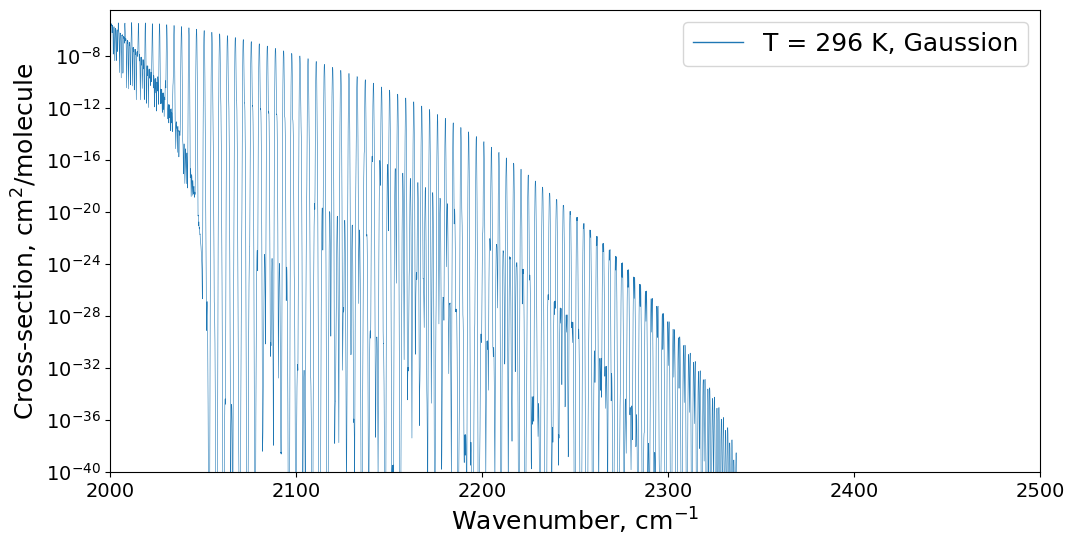

Cross sections plot saved.

The program total running time:
Running time on CPU       : 26.721653145999998 s
Running time on system    : 15.414628505706787 s

Finished!


In [118]:
get_results(read_path)